# Main notebook of our project

## This project consists of 3 major parts 
- General information in movies
- Bechdel test data
    - SVM model + taking into account the proportion of women
    - GPT2 model : finetuning on bechdel test + running on all movies
    - Comparison of both models
- Feminism :
    - Creation of our own dataset of feminist movies
    - GPT2 model : finetuning on feminism dataset + running on all movies
    - Use of this data to create graphs and interactive plots
    - Graph Theory :
        - Clustering
        - Interaction visualization


        

Start by importing all the necessary elements for the project by running the next cell :

# Imports 

In [53]:
from helpers import *
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import ast
import dash
from dash import Dash, dcc, html, Input, Output
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import os
import sys
import plotly.express as px
import json
import matplotlib.cm as cm
import networkx as nx
import random
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
import numpy as np
import matplotlib.colors as mcolors
import matplotlib
from keybert import KeyBERT

from constants import genres_grouped 

# Functions

In [2]:
# Function to preprocess genre column
def extract_genres(genre_str):
    try:
        # Convert the genre string (which is in JSON format) to a dictionary
        genre_dict = json.loads(genre_str)
        # Extract genre names from the dictionary (the values)
        genres = list(genre_dict.values())
        return genres
    except Exception as e:
        # In case of an error in parsing, return an empty list or handle the error appropriately
        return []
    
def extract_year(date_str):
        if pd.isna(date_str):  # Check if the value is NaN
            return None  # Return None or a suitable placeholder for NaN
        if len(date_str) == 4:  # Check if it's a four-digit year
            return int(date_str)  # Return the year as an integer
        return pd.to_datetime(date_str, errors='coerce').year  # Convert to datetime and extract year


# Data preparation

In [4]:
# Define paths - modify them according to your own data location : 
file_source = '/Volumes/LaCie/ADA/2024/Projet/'  # Main data folder
reviews_path = '/Users/shrinidhivelan/Downloads/TMDB_movie_dataset_v11.csv'  # Reviews dataset path
bechdel_path = '/Users/shrinidhivelan/Desktop/DATA ADA Projet/movies.csv'  # Bechdel test dataset path
bechdel_path2 = '/Users/shrinidhivelan/Desktop/DATA ADA Projet/(1) Feminism/movies.csv'  # Feminism dataset path

# Create datasets
MovieMetadata_df, CharacterMetadata_df, names_df, plot_summaries_df, tvTropes_df, merged_Movie = create_datasets(file_source, reviews_path)

# Load reviews dataset
reviews = pd.read_csv(reviews_path)

# Parse dictionaries in MovieMetadata_df
#MovieMetadata_df['Country dictionnaire'] = MovieMetadata_df['Movie countries (Freebase ID:name tuples)'].apply(ast.literal_eval)
#MovieMetadata_df['Genre dictionnaire'] = MovieMetadata_df['Movie genres (Freebase ID:name tuples)'].apply(ast.literal_eval)
#MovieMetadata_df['Language dictionnaire'] = MovieMetadata_df['Movie languages (Freebase ID:name tuples)'].apply(ast.literal_eval)

# Merge plot summaries with movie names
movie_names_summaries_df = pd.merge(plot_summaries_df, MovieMetadata_df, on='Wikipedia movie ID', how='left')
movie_names_character_df = pd.merge(CharacterMetadata_df, MovieMetadata_df, on='Wikipedia movie ID', how='left')

# Load Bechdel test dataset and merge
bechdel_2 = pd.read_csv(bechdel_path2)

Movie_data_bechdel_notation_df = pd.merge(
    MovieMetadata_df, 
    bechdel_2[["title", "year", "bt_score"]], 
    left_on="Movie name", 
    right_on="title", 
    how="inner"
)

# Prepare data for model labels
summaries_bechdel_movies_df = pd.merge(
    plot_summaries_df, 
    Movie_data_bechdel_notation_df, 
    on='Wikipedia movie ID', 
    how='inner'
)

summaries_label = summaries_bechdel_movies_df[['Summaries', 'Movie name', 'bt_score']]

In [54]:
oscars_df = pd.read_csv(file_source + 'Prediction csv files/oscars_df.csv')
columns_to_keep = ['Film', 'Award', 'IMDB Rating']
oscars_df = oscars_df[columns_to_keep]

# Part 1 - General information in movies

## Gender Study

In [ ]:
#Jointure Country/Genre/box Office in CharacterMetadata_df

MovieMetadata_df_filtered = MovieMetadata_df[['Wikipedia movie ID', 'Movie countries (Freebase ID:name tuples)',
                                              'Movie genres (Freebase ID:name tuples)', 'Country dictionnaire', 'Genre dictionnaire', 
                                              'Movie box office revenue' ]]

CharacterMetadata_df = pd.merge(CharacterMetadata_df,MovieMetadata_df_filtered, on = 'Wikipedia movie ID', how='left' )


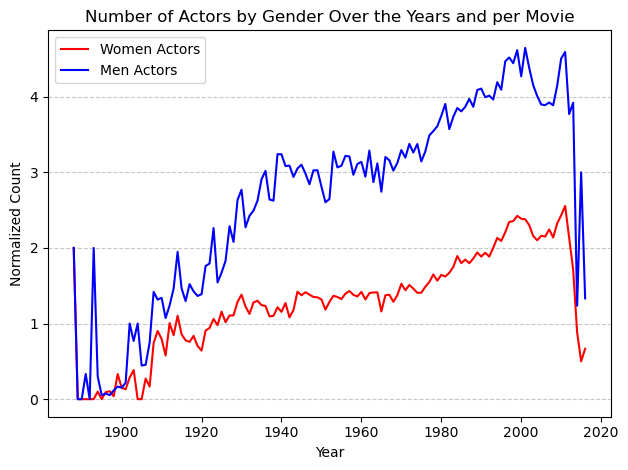

In [ ]:

women_actor = CharacterMetadata_df[CharacterMetadata_df['Actor gender'] == 'F']
men_actor = CharacterMetadata_df[CharacterMetadata_df['Actor gender'] == 'M']

count_women = women_actor['Year'].value_counts().sort_index()
count_men = men_actor['Year'].value_counts().sort_index()

all_years = range(min(count_women.index.min(), count_men.index.min()), 
                  max(count_women.index.max(), count_men.index.max()) + 1)

count_women = count_women.reindex(all_years, fill_value=0)
count_men = count_men.reindex(all_years, fill_value=0)

movies_per_year = MovieMetadata_df['Year'].value_counts().sort_index().reindex(all_years, fill_value=0)

plt.plot(count_women.index, count_women.values / movies_per_year.values, label='Women Actors', color='red')
plt.plot(count_men.index, count_men.values / movies_per_year.values, label='Men Actors', color='blue')

plt.xlabel('Year')
plt.ylabel('Normalized Count')
plt.title('Number of Actors by Gender Over the Years and per Movie')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Number of Actor by Gender over the Years and per country

In [ ]:
# Step 1: Compute the number of female and male actors in each movies 
count_gender = CharacterMetadata_df.groupby(['Wikipedia movie ID', 'Actor gender']).size().unstack(fill_value=0)

movie_info = CharacterMetadata_df[['Wikipedia movie ID', 'Year', 'Movie countries (Freebase ID:name tuples)', 
                                   'Movie genres (Freebase ID:name tuples)']].drop_duplicates()
# Step 2: Added movie data (country, genre)
result = pd.merge(count_gender, movie_info, on='Wikipedia movie ID', how='left')

result['Country dictionnaire'] = result['Movie countries (Freebase ID:name tuples)'].apply(ast.literal_eval)
result['Genre dictionnaire'] = result['Movie genres (Freebase ID:name tuples)'].apply(ast.literal_eval)

result_exploded = result.explode('Country dictionnaire')
# Step 3: Compute the number of  female and male actors for each country and per year
count_gender = result_exploded.groupby(['Year', 'Country dictionnaire']).agg({'F': 'sum', 'M': 'sum'}).reset_index()

# Step 4: Compute the number of movies per year and per country
movies_per_country = result_exploded.groupby(['Year', 'Country dictionnaire']).size().reset_index(name='movies_count')

count_gender = pd.merge(count_gender, movies_per_country, on=['Year', 'Country dictionnaire'])

# Step 5: Normalisation of the results 
count_gender['F_normalized'] = count_gender['F'] / count_gender['movies_count']
count_gender['M_normalized'] = count_gender['M'] / count_gender['movies_count']

count_gender['Ratio']= count_gender['F_normalized']/count_gender['M_normalized']

## Step 6: We only take into account the 5 countries that produce the most films
top_countries = count_gender.groupby('Country dictionnaire')['movies_count'].sum().nlargest(5).index
top_countries_data = count_gender[count_gender['Country dictionnaire'].isin(top_countries)]

top_countries_name = ['United States of America', "India", 'United Kingdom', 'France', 'Italy']
top_countries_data_filtered = top_countries_data[(top_countries_data['Year'] >= 1920) & (top_countries_data['Year'] < 2008) ]

fig, ax = plt.subplots(figsize=(10, 6))

for i, country in enumerate(top_countries):
    country_data = top_countries_data_filtered[top_countries_data_filtered['Country dictionnaire'] == country]
    ax.plot(country_data['Year'], country_data['Ratio'], label=f'{top_countries_name[i]}')

ax.set_title('Ratio of Female to Male Actors in Top 5 Movie-Producing Countries (From 1920)')
ax.set_xlabel('Year')
ax.set_ylabel('Female to Male Actor Ratio')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#save the plot in html format
fig = go.Figure()

for i, country in enumerate(top_countries):
    country_data = top_countries_data_filtered[top_countries_data_filtered['Country dictionnaire'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['Year'],
        y=country_data['Ratio'],
        mode='lines',
        name=f'{top_countries_name[i]}'
    ))

fig.update_layout(
    title='Ratio of Female to Male Actors in Top 5 Movie-Producing Countries (From 1920)',
    xaxis_title='Year',
    yaxis_title='Female to Male Actor Ratio',
    template='plotly_white',
    legend=dict(title="Countries"),
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

fig.write_html("female_to_male_actor_ratio_per_country.html")

## Interactive plot gender/by period/percentage actresses

In [ ]:
result.drop(columns = ['Country dictionnaire', 'Genre dictionnaire'])
result['genres'] = result['Movie genres (Freebase ID:name tuples)'].apply(extract_genres)

# Exploding the genres into separate rows, as a movie can belong to multiple genres
result= result.explode('genres')
genre_to_group = {}
for group, genres_list in genres_grouped.items():
    for genre in genres_list:
        genre_to_group[genre] = group

def categorize_genre(genre):
    return genre_to_group.get(genre, 'Other')

# We gather all types of genre in different categories for better readability.
result['genre_general'] = result['genres'].apply(categorize_genre)
result['Period'] = pd.cut(
    result['Year'], 
    bins=[1940, 1960, 1980, 2020], 
    labels=['1940-1960', '1960-1980', '1980-2020'],
    right=False
)

grouped = result.groupby(['genre_general', 'Period'])[['F', 'M']].sum().reset_index()

grouped['Total'] = grouped['F'] + grouped['M']
grouped['F_Percentage'] = (grouped['F'] / grouped['Total']) * 100
grouped['M_Percentage'] = (grouped['M'] / grouped['Total']) * 100

data = {}
for genre in grouped['genre_general'].unique():
    genre_data = grouped[grouped['genre_general'] == genre]
    periods = {
        period: {
            "Male": genre_data[genre_data['Period'] == period]['M_Percentage'].values[0] if not genre_data[genre_data['Period'] == period].empty else 0,
            "Female": genre_data[genre_data['Period'] == period]['F_Percentage'].values[0] if not genre_data[genre_data['Period'] == period].empty else 0
        }
        for period in ['1940-1960', '1960-1980', '1980-2020']
    }
    data[genre] = periods

final_df = pd.DataFrame.from_dict(data, orient='index')

,Wikipedia movie ID,F,M,Year,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),genres,genre_general,Period
0,330,4,0,1996,"{""/m/06mkj"": ""Spain""}","{""/m/07s9rl0"": ""Drama"", ""/m/01t_vv"": ""Comedy-d...",Drama,Drama,1980-2020
0,330,4,0,1996,"{""/m/06mkj"": ""Spain""}","{""/m/07s9rl0"": ""Drama"", ""/m/01t_vv"": ""Comedy-d...",Comedy-drama,Comedy,1980-2020
1,3217,3,10,1992,"{""/m/09c7w0"": ""United States of America""}","{""/m/01q03"": ""Cult"", ""/m/03npn"": ""Horror"", ""/m...",Cult,Cult,1980-2020
1,3217,3,10,1992,"{""/m/09c7w0"": ""United States of America""}","{""/m/01q03"": ""Cult"", ""/m/03npn"": ""Horror"", ""/m...",Horror,Horror and Thriller,1980-2020
1,3217,3,10,1992,"{""/m/09c7w0"": ""United States of America""}","{""/m/01q03"": ""Cult"", ""/m/03npn"": ""Horror"", ""/m...",Stop motion,Miscellaneous Other Genres,1980-2020
...,...,...,...,...,...,...,...,...,...
63649,37476824,4,6,2011,"{""/m/03rk0"": ""India""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/016vh2"": ""Ca...",Caper story,Crime and Mystery,1980-2020
63649,37476824,4,6,2011,"{""/m/03rk0"": ""India""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/016vh2"": ""Ca...",Crime Comedy,Experimental,1980-2020
63649,37476824,4,6,2011,"{""/m/03rk0"": ""India""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/016vh2"": ""Ca...",Comedy,Comedy,1980-2020
63650,37478048,1,3,1996,{},"{""/m/05p553"": ""Comedy film""}",Comedy film,Comedy,1980-2020


In [ ]:
genres = final_df.index.tolist()
periods = final_df.columns.tolist()


app = Dash(__name__)

app.layout = html.Div([
    html.H1("Actor Gender Repartition per Movie Genre and Period", style={'textAlign': 'center'}),
    dcc.Graph(id="pie-chart"),
    html.Div([
        html.Label("Select Genre:"),
        dcc.Dropdown(
            id="genre-dropdown",
            options=[{"label": genre, "value": genre} for genre in genres],
            value=genres[0],
            clearable=False,
        ),
    ], style={"margin-bottom": "20px", "width": "50%"}), 
    html.Div([
        html.Label("Select Period:"),
        dcc.Dropdown(
            id="period-dropdown",
            options=[{"label": period, "value": period} for period in periods],
            value=periods[0], 
        ),
    ], style={"margin-bottom": "20px", "width": "50%"}),  
])

@app.callback(
    Output("pie-chart", "figure"),
    [Input("genre-dropdown", "value"), Input("period-dropdown", "value")]
)
def update_pie_chart(selected_genre, selected_period):
    data = final_df.loc[selected_genre, selected_period]
    male_percentage = data['Male']
    female_percentage = data['Female']
    
    labels = ["Male", "Female"]
    values = [male_percentage, female_percentage]
    
    fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=0.4)])
    fig.update_layout(
        title=f"Genre: {selected_genre} | Period: {selected_period}",
        title_x=0.5,
    )
    return fig

if __name__ == "__main__":
    app.run_server(debug=True, port=8050)

In [ ]:
female_total = 0
count = 0 

for genre in final_df.index:
    for period in final_df.columns:
        data = final_df.loc[genre, period]
        female_total += data['Female']
        count += 1
#Mean
female_avg = female_total / count

print(f"Female Average Percentage: {female_avg}%")

Female Average Percentage: 30.433789786838748%


## Age of actors relative to their gender by decade

In [ ]:
age_actors = CharacterMetadata_df[CharacterMetadata_df['Actor age at movie release'] > 0].copy()

# gather by decade
age_actors['Period'] = pd.cut(
    age_actors['Year'], 
    bins=[1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010], 
    labels=['1930-1940', '1940-1950', '1950-1960', '1960-1970', '1970-1980', '1980-1990', '1990-2000', '2000-2010'],
    right=False
)

app = dash.Dash(__name__)

periods = ['1930-1940', '1940-1950', '1950-1960', '1960-1970','1970-1980', '1980-1990', '1990-2000', '2000-2010']

app.layout = html.Div([
    dcc.Slider(
        id='period-slider',
        min=0,
        max=len(periods) - 1,
        step=1,
        marks={i: periods[i] for i in range(len(periods))},
        value=0,  # Par défaut la première période
    ),
    dcc.Graph(id='age-distribution-graph')
])

@app.callback(
    Output('age-distribution-graph', 'figure'),
    Input('period-slider', 'value')
)
def update_graph(selected_period):
    period = periods[selected_period]
    filtered_data = age_actors[age_actors['Period'] == period]
    
    if filtered_data.empty:
        return {
            'data': [],
            'layout': {
                'title': f'Aucune donnée disponible pour la période {period}',
                'xaxis': {'title': 'Age'},
                'yaxis': {'title': 'Count'},
            }
        }
    
    color_map = {'M': 'blue', 'F': 'red'} 
    fig = px.histogram(
        filtered_data,
        x='Actor age at movie release',
        color='Actor gender',
        title=f'Distribution of actors’ ages for the period {period}',
        nbins=20,  
        opacity=0.5, 
        labels={'Actor age at movie release': 'Actors age ', 'Actor gender': 'Gender'},
        histnorm='density', 
        color_discrete_map=color_map,
        barmode='group'  
    )

    return fig

#if __name__ == '__main__':
#    app.run_server(debug=True, port='8052')

app.run_server(debug=True, port='8053')

# Part 2 - Bechdel test

### Train the GPT2 model

In [ ]:
import pandas as pd
from gpt.feminism_gpt_classifier import *
from transformers import GPT2Tokenizer, GPT2Model
import torch
import torch.nn as nn
from datasets import Dataset

feminism_indicator = summaries_label.copy()
feminism_indicator['feminism'] = feminism_indicator['bt_score'].apply(lambda x: 1 if x == 3 else 0)

# Train the model - and saved under best_bin_model.bin
model, metrics = train_feminism_classifier(feminism_indicator)

# Load the pre-trained GPT2 model
gpt_model = GPT2Model.from_pretrained('gpt2')

# Load the GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # GPT2 does not have a pad token by default

# Define the number of classes (assuming binary classification)
num_classes = 2  
model = GPTClassifier(gpt_model, num_classes)

# Load the saved model weights - as this could avoid training the model again
model.load_state_dict(torch.load('best_model_state.bin'))
model.eval()  # Set the model to evaluation mode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import pandas as pd

# Load the dataset
movie_dataset = pd.read_csv('Prediction csv files/movies_gpt2_prediction.csv')

df = movie_dataset.copy()
# Predict on all movies
new_predictions = df['feminism'].values

# Convert predictions to boolean values (True for feminist movie, False otherwise)
bool_new_predictions = [True if prediction == 1 else False for prediction in new_predictions]

# Add the predictions as a new column to the dataframe
movie_names_summaries_df['prediction'] = bool_new_predictions

# Count the total number of movies per year
count_per_year_all = movie_names_summaries_df.groupby('Year').size().reset_index(name='total_movies')

# Count the number of feminist movies per year
feminist_count = movie_names_summaries_df[movie_names_summaries_df['prediction'] == True]
count_per_year_feminist = feminist_count.groupby('Year').size().reset_index(name='feminist_movies')

# Merge the two counts on 'Year'
merged_counts = pd.merge(count_per_year_all, count_per_year_feminist, on='Year', how='left')

# Fill missing values with 0 (if no feminist movies are present for that year)
merged_counts['feminist_movies'] = merged_counts['feminist_movies'].fillna(0)

# Calculate the percentage of feminist movies
merged_counts['feminist_percentage'] = merged_counts['feminist_movies'] / merged_counts['total_movies'] * 100

# Plotting the stacked bar chart
plt.figure(figsize=(12, 8))

# Plot the overall number of movies
plt.bar(merged_counts['Year'], merged_counts['total_movies'], color='lightgray', label='Total Movies')

# Plot the feminist movies on top (stacked)
plt.bar(merged_counts['Year'], merged_counts['feminist_movies'], color='salmon', label='Feminist Movies')

# Labeling
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Total and Feminist Movies per Year')

# Show the percentage of feminist movies on top of the bars every 10 years
for i, row in merged_counts.iterrows():
    if row['Year'] % 10 == 0:  # Show only every 10 years
        plt.text(row['Year'], row['total_movies'] + 5, f"{row['feminist_percentage']:.1f}%", ha='center', va='bottom')

# Add grid and legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Display the plot
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

NameError: name 'movie_names_summaries_df' is not defined

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# Assuming you have your merged_counts DataFrame ready from your previous code

fig = go.Figure()

# Add total movies bar (gray)
fig.add_trace(go.Bar(
    x=merged_counts['Year'],
    y=merged_counts['total_movies'],
    name='Total Movies',
    marker_color='lightgray'
))

# Add feminist movies bar (salmon) as part of total movies
fig.add_trace(go.Bar(
    x=merged_counts['Year'],
    y=merged_counts['feminist_movies'],
    name='Feminist Movies',
    marker_color='salmon'
))

# Add percentage text on top of the bars
for i, row in merged_counts.iterrows():
    if row['Year'] % 10 == 0:  # Show only every 10 years
        fig.add_annotation(
            x=row['Year'],
            y=row['total_movies'] + 5,
            text=f"{row['feminist_percentage']:.1f}%",
            showarrow=False,
            font=dict(size=12),
            align='center'
        )

# Update layout for better appearance
fig.update_layout(
    title="Total and Feminist Movies per Year",
    xaxis_title="Year",
    yaxis_title="Number of Movies",
    barmode='group',  # Use 'group' to show side-by-side bars instead of stacking
    template='plotly_white',
    xaxis=dict(tickangle=90),  # Rotate x-axis labels
    legend_title="Movie Type"
)

# Save the figure as an interactive HTML file
fig.write_html('feminist_movies_interactive.html')

# Show the figure (optional)
fig.show()


In [ ]:
predictions_gpt_df = pd.read_csv(file_source+'Prediction csv files/movies_gpt2_prediction.csv')
predictions_gpt_df = predictions_gpt_df.rename(columns={'feminism':"prediction_gpt"})
predictions_SVM_df = pd.read_csv(file_source+'Prediction csv files/movies_svm_predictions.csv')
predictions_SVM_df = predictions_SVM_df.rename(columns={'Feminism prediction':"prediction_svm"})
columns_to_keep = ['Wikipedia movie ID', 'prediction_svm']
predictions_SVM_df = predictions_SVM_df[columns_to_keep]
predictions_df = pd.merge(predictions_gpt_df, predictions_SVM_df, left_on='Wikipedia movie ID',right_on='Wikipedia movie ID', how='outer')
predictions_df.loc[predictions_df['prediction_svm'].isna(), 'prediction_svm'] = 1
predictions_df['is_equal'] = predictions_df['prediction_svm'] == predictions_df['prediction_gpt']
predictions_df['Year'] = predictions_df['Movie release date'].apply(extract_year)

## Number of movies that pass the test per year par year

### GPT model

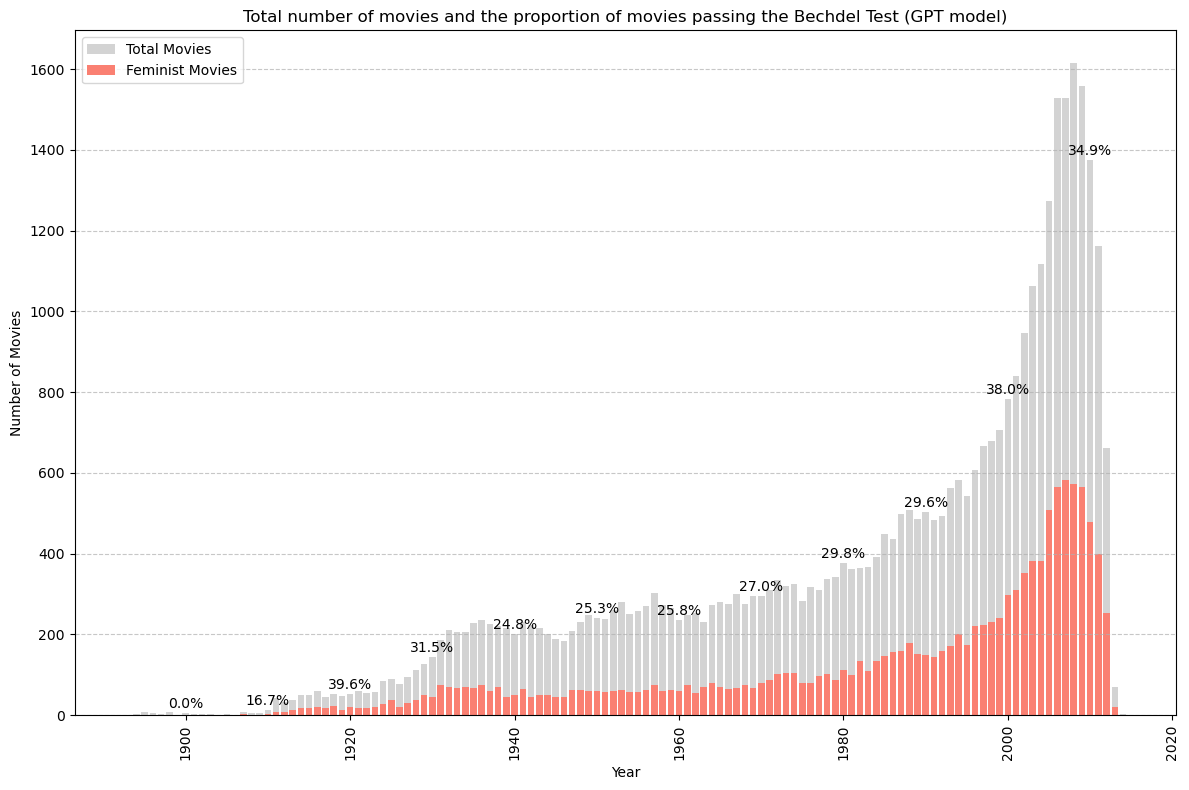

In [36]:
# Count the total number of movies per year
count_per_year_all = predictions_df.groupby('Year').size().reset_index(name='total_movies')

# Count the number of feminist movies per year
feminist_count_gpt = predictions_df[predictions_df['prediction_gpt'] == True]
count_per_year_gpt = feminist_count_gpt.groupby('Year').size().reset_index(name='feminist_movies')

# Merge the two counts on 'Year'
merged_counts = pd.merge(count_per_year_all, count_per_year_gpt, on='Year', how='left')

# Fill missing values with 0 (if no feminist movies are present for that year)
merged_counts['feminist_movies'] = merged_counts['feminist_movies'].fillna(0)

# Calculate the percentage of feminist movies
merged_counts['feminist_percentage'] = merged_counts['feminist_movies'] / merged_counts['total_movies'] * 100

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(merged_counts['Year'], merged_counts['total_movies'], color='lightgray', label='Total Movies')

# Plot the feminist movies on top (stacked)
ax.bar(merged_counts['Year'], merged_counts['feminist_movies'], color='salmon', label='Feminist Movies')

# Labeling
ax.set_xlabel('Year')
ax.set_ylabel('Number of Movies')
ax.set_title('Total number of movies and the proportion of movies passing the Bechdel Test (GPT model)')

# Show the percentage of feminist movies on top of the bars every 10 years
for i, row in merged_counts.iterrows():
    if row['Year'] % 10 == 0:  # Show only every 10 years
        ax.text(row['Year'], row['total_movies'] + 5, f"{row['feminist_percentage']:.1f}%", ha='center', va='bottom')

ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()

plot1 = fig

plt.show()


### SVM model

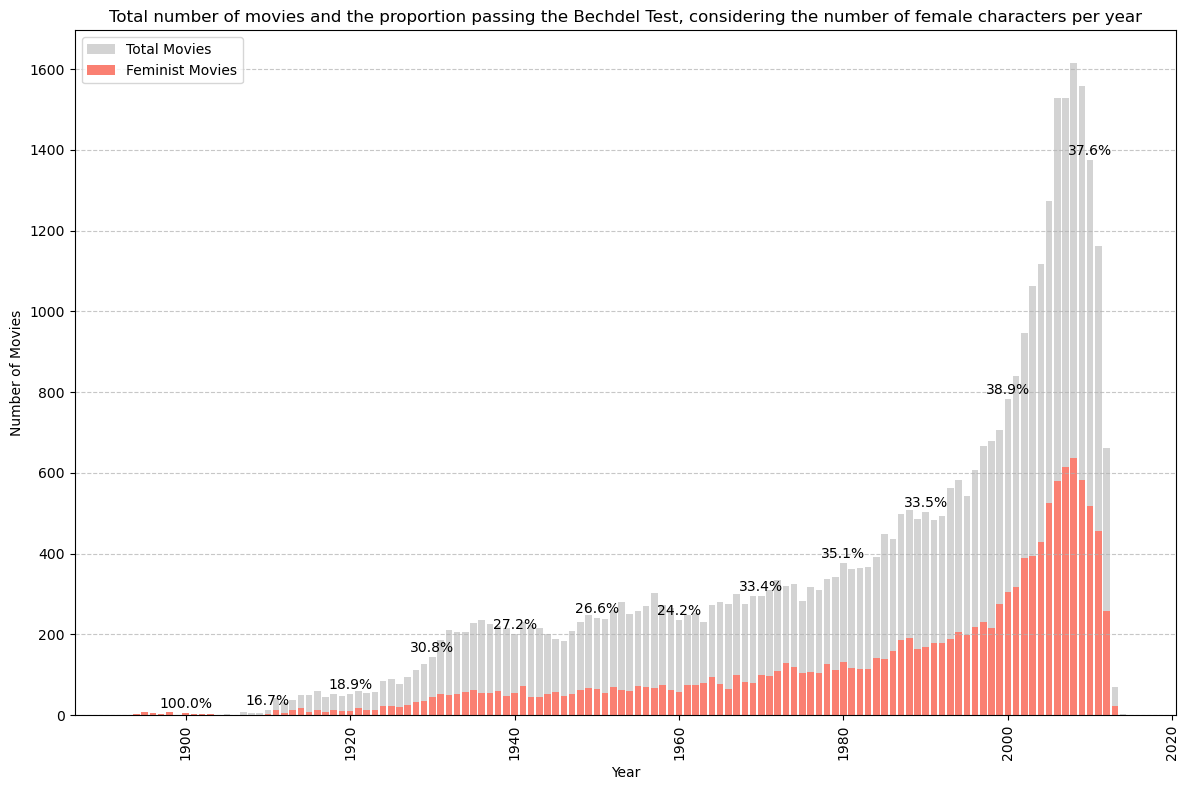

In [37]:
# Count the number of feminist movies per year
feminist_count_svm = predictions_df[predictions_df['prediction_svm'] == True]
count_per_year_svm = feminist_count_svm.groupby('Year').size().reset_index(name='feminist_movies')

# Merge the two counts on 'Year'
merged_counts = pd.merge(count_per_year_all, count_per_year_svm, on='Year', how='left')

# Fill missing values with 0 (if no feminist movies are present for that year)
merged_counts['feminist_movies'] = merged_counts['feminist_movies'].fillna(0)

# Calculate the percentage of feminist movies
merged_counts['feminist_percentage'] = merged_counts['feminist_movies'] / merged_counts['total_movies'] * 100


fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(merged_counts['Year'], merged_counts['total_movies'], color='lightgray', label='Total Movies')

ax.bar(merged_counts['Year'], merged_counts['feminist_movies'], color='salmon', label='Feminist Movies')

ax.set_xlabel('Year')
ax.set_ylabel('Number of Movies')
ax.set_title('Total number of movies and the proportion passing the Bechdel Test, considering the number of female characters per year')

# Show the percentage of feminist movies on top of the bars every 10 years
for i, row in merged_counts.iterrows():
    if row['Year'] % 10 == 0:  # Show only every 10 years
        ax.text(row['Year'], row['total_movies'] + 5, f"{row['feminist_percentage']:.1f}%", ha='center', va='bottom')

ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()

plot2 = fig

plt.show()

***Apply a linear regression to determine a tendency***

In [ ]:
from sklearn.linear_model import LinearRegression

# Define the variables for the lienar regression
X_linear = merged_counts['feminist_percentage'].index
X_linear = np.array(X_linear)
X_linear = X_linear.reshape(-1, 1)
y_linear = merged_counts['feminist_percentage'].values

# Define and fit the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_linear, y_linear)

# Predict using the linear regression model
y_linear_pred = lin_model.predict(X_linear)

# Compute the correlation coefficient 
corr = np.corrcoef(X_linear.flatten(), y_linear)
print("Correlation coefficient :", corr[0,1])

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X_linear, y_linear, color='orange', label='Data')
plt.plot(X_linear, y_linear_pred, color='green', label='Linear Fit')
plt.title('Linear Regression of Normalized Feminist Movies per Year')
plt.xlabel('Year')
plt.ylabel('Proportion of Movies')
plt.legend()
plt.grid(True)
plt.show()

## Percentage of films that pass the test for the 5 producing countries

In [ ]:
predictions_df['Country dictionnaire'] = predictions_df['Movie countries (Freebase ID:name tuples)'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

predictions_df['Genre dictionnaire'] = predictions_df['Movie genres (Freebase ID:name tuples)'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

predictions_explode_country = predictions_df.explode('Country dictionnaire')

predictions_explode_country['passes_bechdel_svm'] = predictions_explode_country['prediction_svm']
predictions_explode_country['passes_bechdel_gpt'] = predictions_explode_country['prediction_gpt']

grouped_svm = predictions_explode_country.groupby(['Country dictionnaire', 'Year']).agg(
    total_movies=('Wikipedia movie ID', 'count'),
    feminist_movies=('passes_bechdel_svm', 'sum')
).reset_index()

grouped_gpt = predictions_explode_country.groupby(['Country dictionnaire', 'Year']).agg(
    total_movies=('Wikipedia movie ID', 'count'),
    feminist_movies=('passes_bechdel_gpt', 'sum')
).reset_index()
films_per_country = predictions_explode_country.groupby('Country dictionnaire').size().reset_index(name='total_movies')
top_5_countries = films_per_country.sort_values(by='total_movies', ascending=False).head(5)
top_countries_name = ['United States of America', "India", 'United Kingdom', 'France', 'Italy']

print(top_5_countries)
grouped_svm['feminist_percentage'] = grouped_svm['feminist_movies'] / grouped_svm['total_movies'] * 100
grouped_gpt['feminist_percentage'] = grouped_gpt['feminist_movies'] / grouped_gpt['total_movies'] * 100

grouped_gpt = grouped_gpt[(grouped_gpt['Year'] >= 1960) & (grouped_gpt['Year'] < 2008)]
grouped_svm = grouped_svm[(grouped_svm['Year'] >= 1960) & (grouped_svm['Year'] < 2008)]

### GPT model 

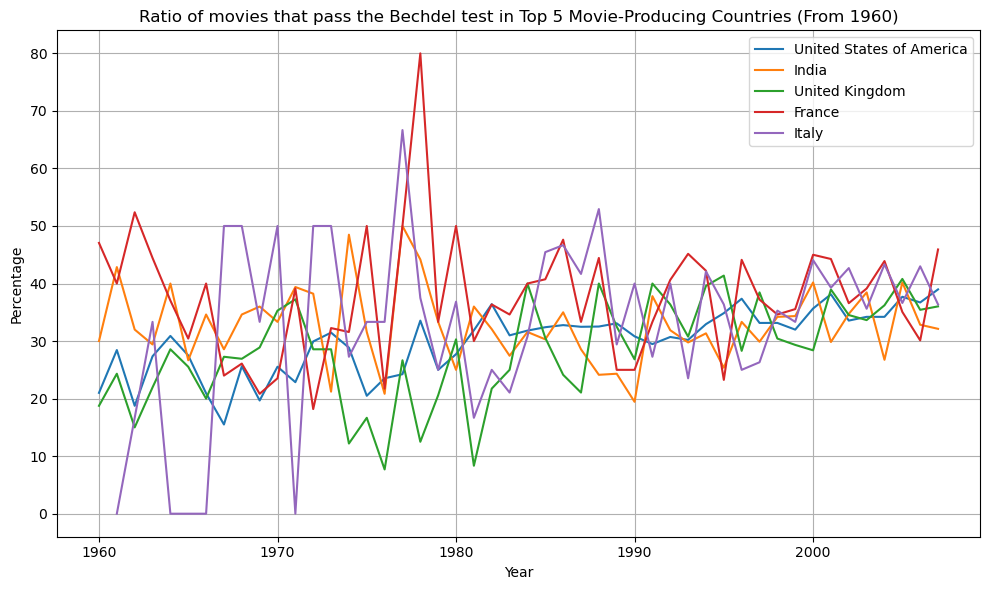

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, country in enumerate(top_5_countries['Country dictionnaire']):
    country_data = grouped_gpt[grouped_gpt['Country dictionnaire'] == country]
    ax.plot(country_data['Year'], country_data['feminist_percentage'], label=f'{top_countries_name[i]}')

ax.set_title('Ratio of movies that pass the Bechdel test in Top 5 Movie-Producing Countries (From 1960)')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [68]:
# Saving in HTML 
fig = go.Figure()
for i, country in enumerate(top_5_countries['Country dictionnaire']):
    country_data = grouped_gpt[grouped_gpt['Country dictionnaire'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['Year'],
        y=country_data['feminist_percentage'],
        mode='lines',
        name=top_countries_name[i],  # Utilise le label du pays
        hovertemplate=f"<b>{top_countries_name[i]}</b><br>Year: {{x}}<br>Percentage: {{y:.2f}}%"  # Format interactif
    ))

fig.update_layout(
    title="Ratio of Movies That Pass the Bechdel Test in Top 5 Movie-Producing Countries (From 1960)",
    xaxis_title="Year",
    yaxis_title="Percentage",
    legend_title="Country",
    template="plotly_white",
    hovermode="x unified" 
)

html_file = "bechdel_test_ratio_per_country_GPT.html"
fig.write_html(html_file)

fig.show()


### SVM model

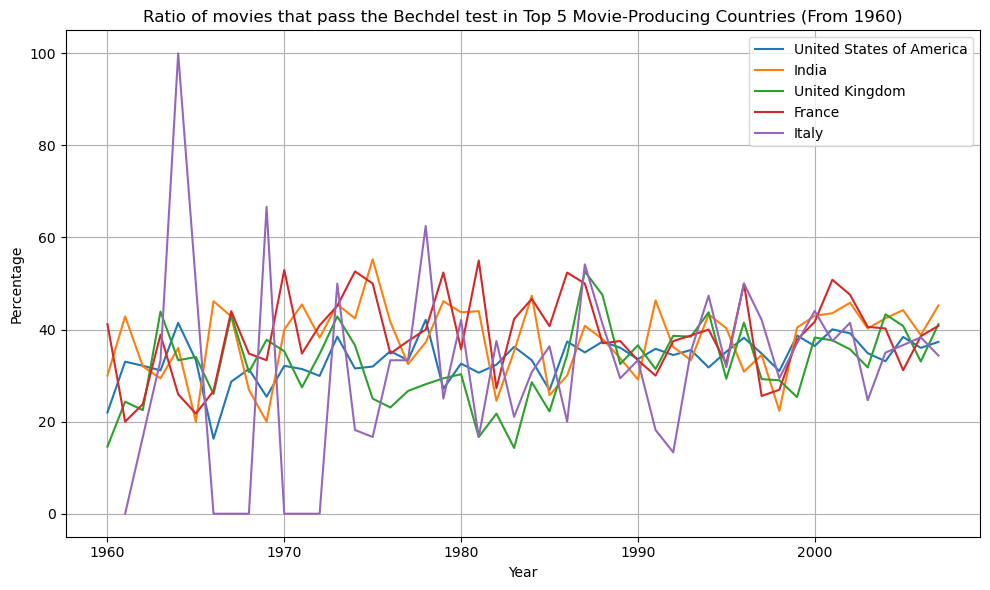

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, country in enumerate(top_5_countries['Country dictionnaire']):
    country_data = grouped_svm[grouped_svm['Country dictionnaire'] == country]
    ax.plot(country_data['Year'], country_data['feminist_percentage'], label=f'{top_countries_name[i]}')

ax.set_title('Ratio of movies that pass the Bechdel test in Top 5 Movie-Producing Countries (From 1960)')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [45]:
#Saving in HTML
fig = go.Figure()
for i, country in enumerate(top_5_countries['Country dictionnaire']):
    country_data = grouped_svm[grouped_svm['Country dictionnaire'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['Year'],
        y=country_data['feminist_percentage'],
        mode='lines',
        name=top_countries_name[i],  # Utilise le label du pays
        hovertemplate=f"<b>{top_countries_name[i]}</b><br>Year: {{x}}<br>Percentage: {{y:.2f}}%"  # Format interactif
    ))

fig.update_layout(
    title="Ratio of Movies That Pass the Bechdel Test in Top 5 Movie-Producing Countries (From 1960)",
    xaxis_title="Year",
    yaxis_title="Percentage",
    legend_title="Country",
    template="plotly_white",
    hovermode="x unified" 
)

html_file = "bechdel_test_ratio_per_country_SVM.html"
fig.write_html(html_file)

fig.show()

## Percentage of films that pass the test for each genre category

In [ ]:
predictions_df['genres'] = predictions_df['Movie genres (Freebase ID:name tuples)'].apply(extract_genres)

genre_to_group = {}
for group, genres_list in genres_grouped.items():
    for genre in genres_list:
        genre_to_group[genre] = group

def categorize_genre(genre):
    return genre_to_group.get(genre, 'Other')

predictions_explode_genre = predictions_df.explode('genres')

predictions_explode_genre['genre_general'] = predictions_explode_genre['genres'].apply(categorize_genre)


movies_per_genre = predictions_explode_genre.groupby(['Year', 'genre_general']).agg(
    pred_gpt = ('prediction_gpt', 'sum'),
    pred_svm = ('prediction_svm', 'sum'),
    nb_total = ('Wikipedia movie ID', 'count')
)
movies_per_genre['percentage_gpt']= movies_per_genre['pred_gpt']/movies_per_genre['nb_total']

movies_per_genre['percentage_svm']= movies_per_genre['pred_svm']/movies_per_genre['nb_total']
movies_per_genre = movies_per_genre.loc[
    (movies_per_genre.index.get_level_values('Year') >= 1940) &
    (movies_per_genre.index.get_level_values('Year') < 2008)
]



### GPT model

/var/folders/dl/y_0dp4yd3sd1cf5mnxcnpt100000gn/T/ipykernel_21964/3809224033.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



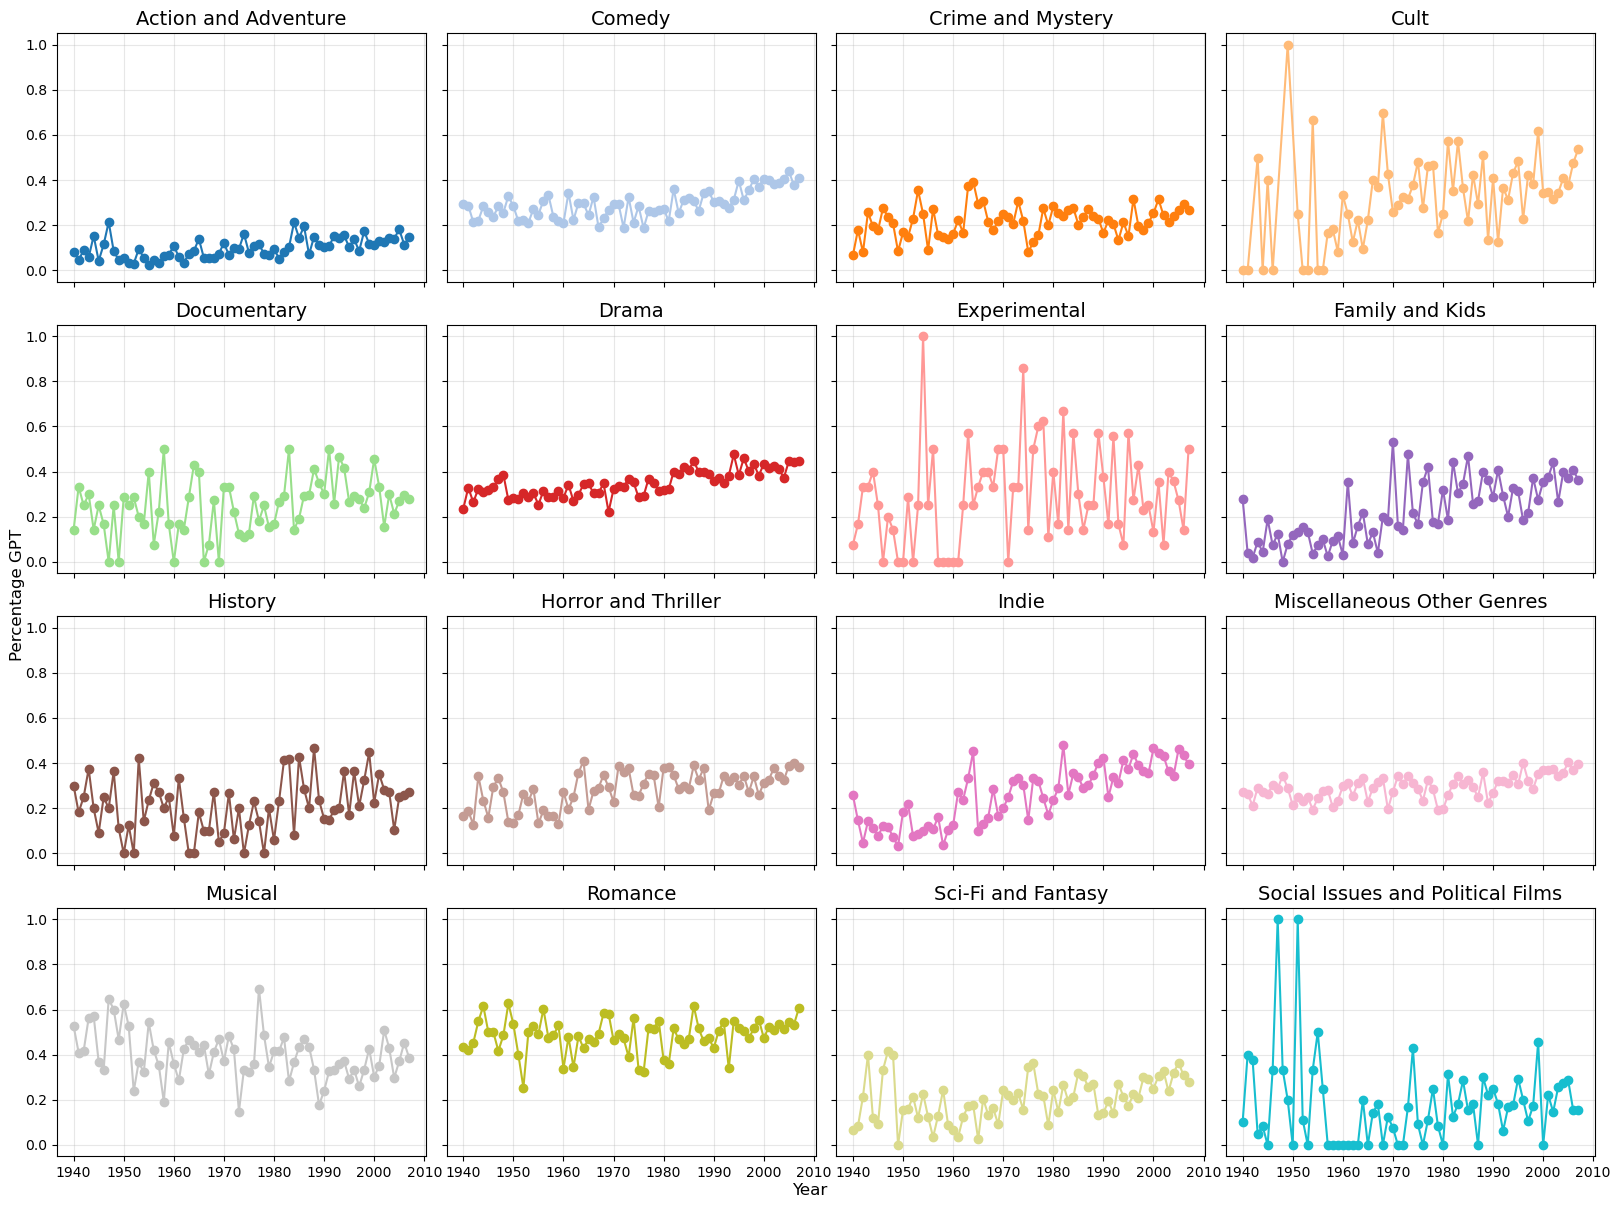

In [ ]:
unique_genres = movies_per_genre.index.get_level_values('genre_general').unique()

colormap = cm.get_cmap('tab20', len(unique_genres))

fig, axes = plt.subplots(4, 4, figsize=(16, 12), sharey=True, sharex=True)

genre_colors = {genre: colormap(i) for i, genre in enumerate(unique_genres)}

title_fontsize = 14

for ax, genre in zip(axes.ravel(), unique_genres):
    genre_data = movies_per_genre.xs(genre, level='genre_general')
    
    ax.plot(genre_data.index, genre_data['percentage_gpt'], marker='o', label=f"{genre}", color=genre_colors[genre])
    
    ax.set_title(genre, fontsize=title_fontsize)
    ax.grid(alpha=0.3)

for ax in axes.ravel()[len(unique_genres):]:
    ax.axis('off')

fig.text(0.5, 0, 'Year', ha='center', fontsize=12)
fig.text(0, 0.5, 'Percentage GPT', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()

output_file = "percentage_gpt_per_genre.png"
fig.savefig(output_file, format='png', dpi=300) 
plt.show()

### SVM model

In [51]:
for ax, genre in zip(axes.ravel(), unique_genres):
    genre_data = movies_per_genre.xs(genre, level='genre_general')
    
    ax.plot(genre_data.index, genre_data['percentage_svm'], marker='o', label=f"{genre}", color=genre_colors[genre])
    
    ax.set_title(genre, fontsize=title_fontsize) 
    ax.grid(alpha=0.3)

for ax in axes.ravel()[len(unique_genres):]:
    ax.axis('off')

fig.text(0.5, 0, 'Year', ha='center', fontsize=12)
fig.text(0, 0.5, 'Percentage SVM', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()

output_file = "percentage_svm_per_genre.png"
fig.savefig(output_file, format='png', dpi=300)

plt.show()

<Figure size 640x480 with 0 Axes>

## Proportion of Movies that pass the test Bechdel in the Box Office

### GPT model

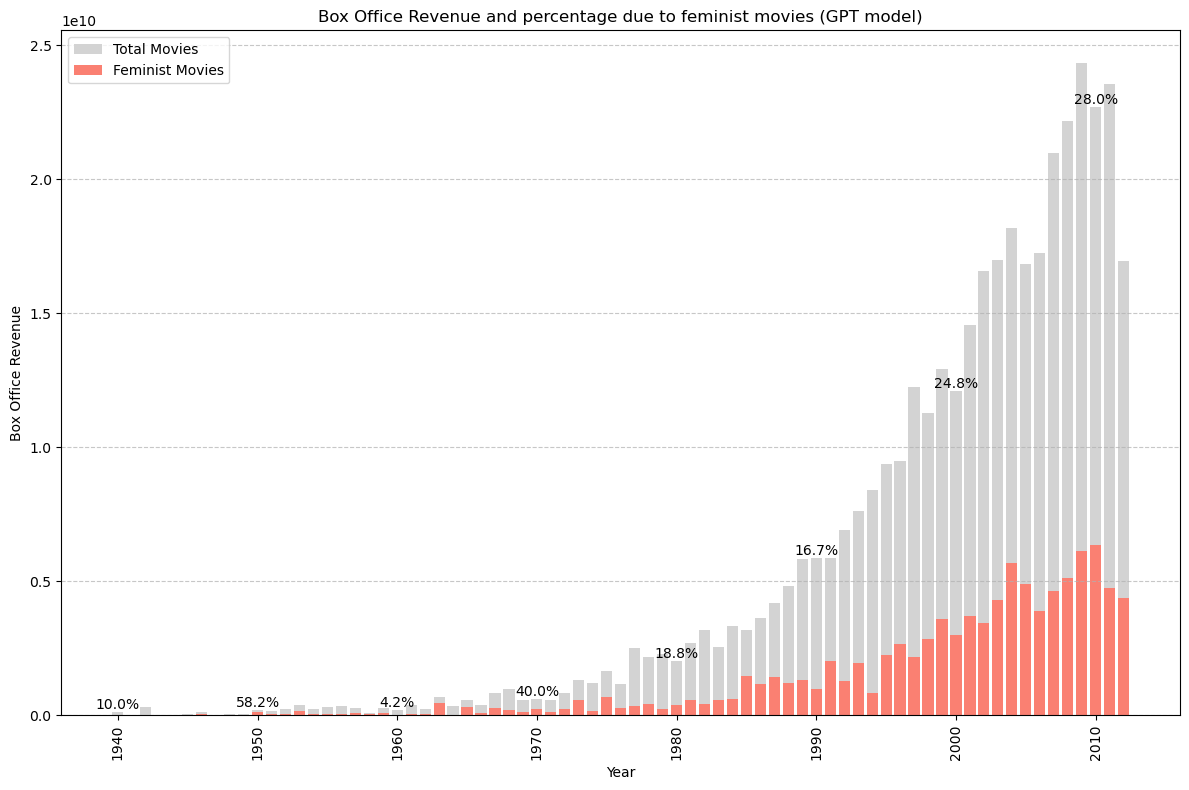

In [52]:
GPT_BOX = predictions_df[['Year','Wikipedia movie ID', 'prediction_gpt', 'Movie box office revenue']].sort_values('Year')

gpt_revenue_year = GPT_BOX.groupby('Year').agg(
    box_office_total = ('Movie box office revenue', 'sum'),
    box_office_fem=('Movie box office revenue', lambda x: x[GPT_BOX['prediction_gpt'] == 1].sum())
)
gpt_revenue_year['ratio'] = 100*gpt_revenue_year['box_office_fem'].div(gpt_revenue_year['box_office_total'])

gpt_revenue_year = gpt_revenue_year['1940':'2013']

plt.figure(figsize=(12, 8))

plt.bar(gpt_revenue_year.index, gpt_revenue_year['box_office_total'], color='lightgray', label='Total Movies')

plt.bar(gpt_revenue_year.index, gpt_revenue_year['box_office_fem'], color='salmon', label='Feminist Movies')

plt.xlabel('Year')
plt.ylabel('Box Office Revenue')
plt.title('Box Office Revenue and percentage due to feminist movies (GPT model)')

for year, row in gpt_revenue_year.iterrows():
    if int(year) % 10 == 0: 
        plt.text(
            year,
            row['box_office_total'] + 5,
            f"{row['ratio']:.1f}%",
            ha='center', va='bottom'
        )

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()


plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

### SVM model

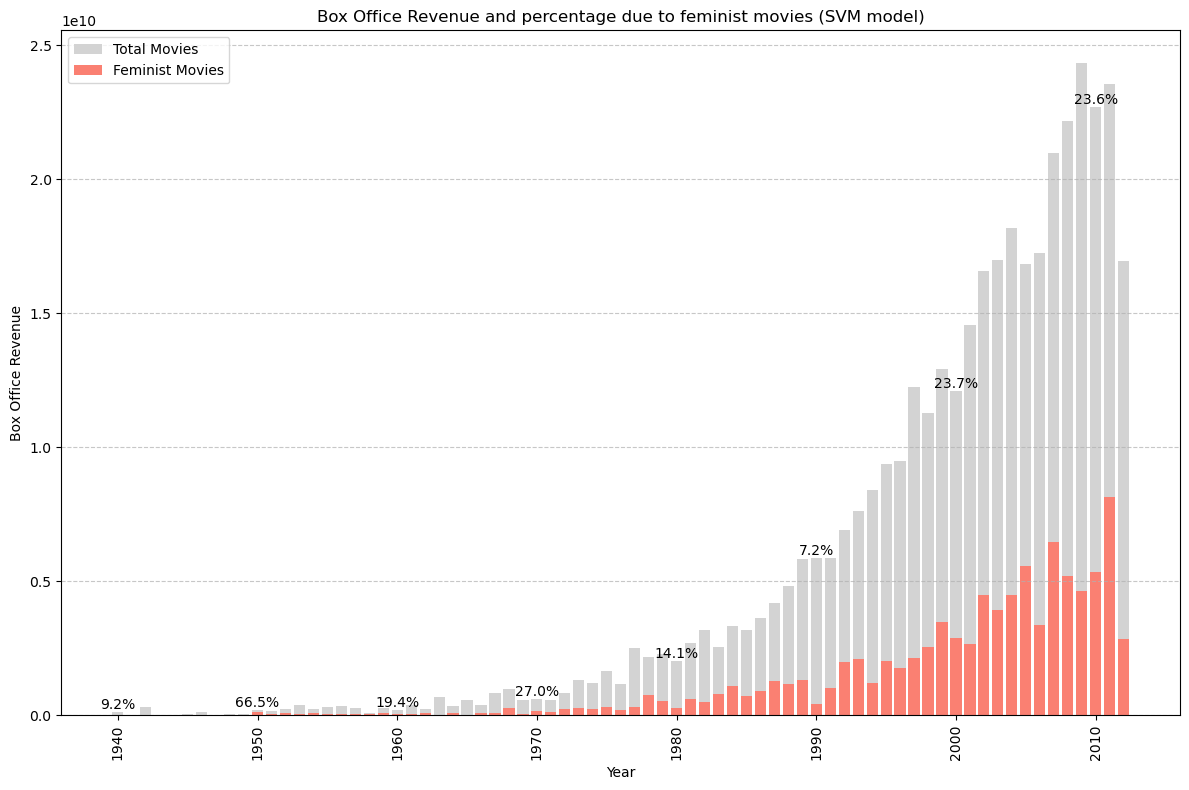

In [ ]:
SVM_BOX = predictions_df[['Year','Wikipedia movie ID', 'prediction_svm', 'Movie box office revenue']].sort_values('Year')

svm_revenue_year = SVM_BOX.groupby('Year').agg(
    box_office_total = ('Movie box office revenue', 'sum'),
    box_office_fem=('Movie box office revenue', lambda x: x[SVM_BOX['prediction_svm'] == 1].sum())
)
svm_revenue_year['ratio'] = 100*svm_revenue_year['box_office_fem'].div(svm_revenue_year['box_office_total'])

svm_revenue_year = svm_revenue_year['1940':'2013']

plt.figure(figsize=(12, 8))

plt.bar(svm_revenue_year.index, svm_revenue_year['box_office_total'], color='lightgray', label='Total Movies')

plt.bar(svm_revenue_year.index, svm_revenue_year['box_office_fem'], color='salmon', label='Feminist Movies')

plt.xlabel('Year')
plt.ylabel('Box Office Revenue')
plt.title('Box Office Revenue and percentage due to feminist movies (SVM model)')

for year, row in svm_revenue_year.iterrows(): 
    if int(year) % 10 == 0: 
        plt.text(
            year,
            row['box_office_total'] + 5,
            f"{row['ratio']:.1f}%",
            ha='center', va='bottom'
        )

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()


## Percentage of Oscar-winning films that pass the Bechdel test

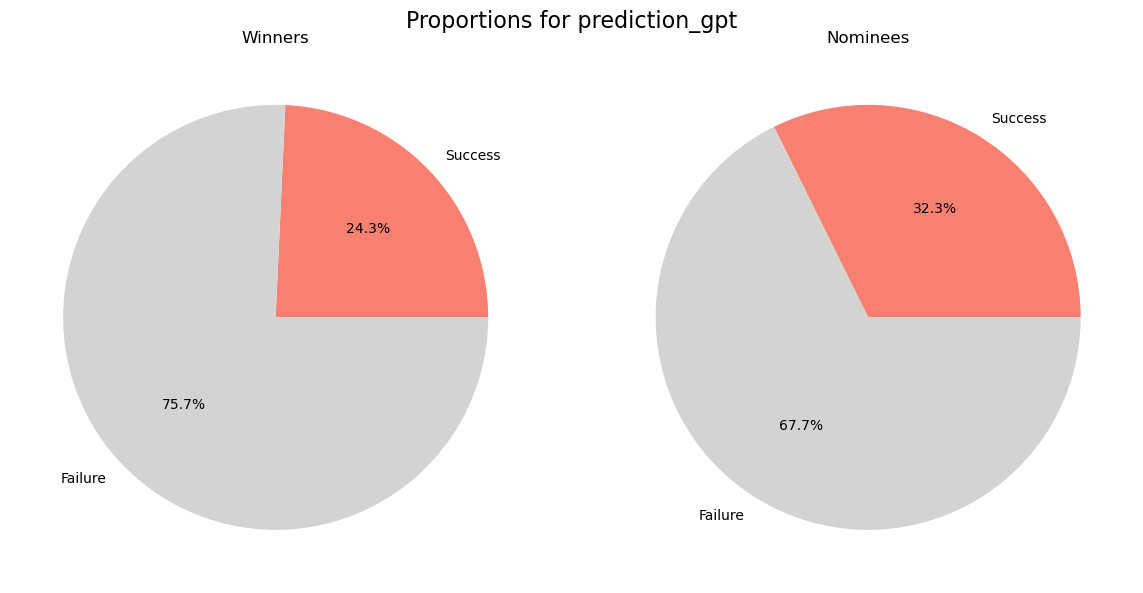

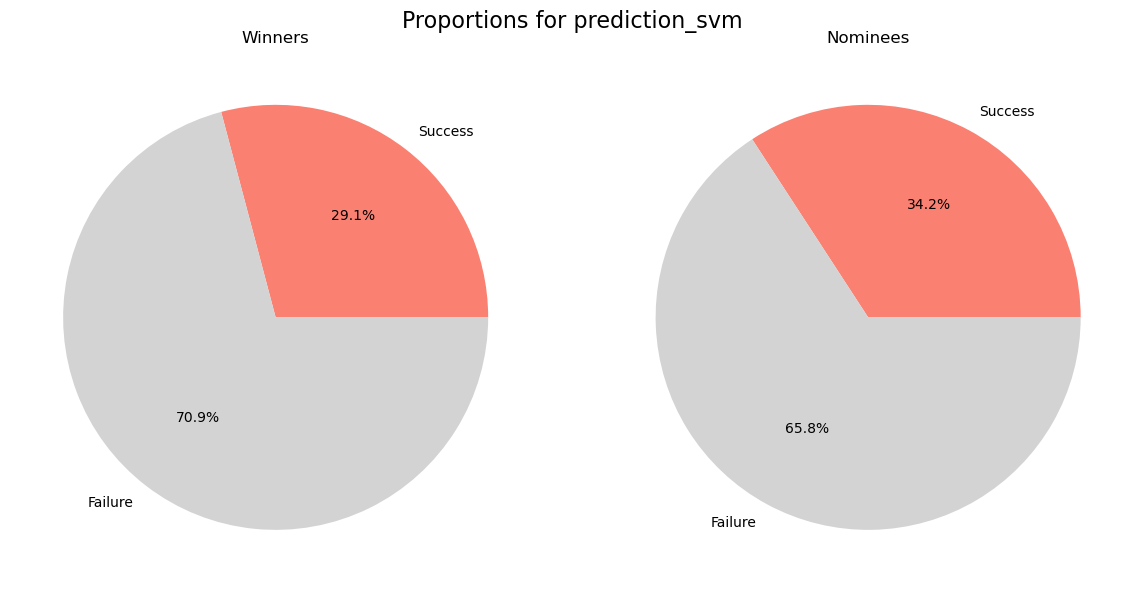

In [ ]:
oscars_percentage = pd.merge(predictions_df, oscars_df, left_on = 'Movie name', right_on = 'Film', how='inner')
columns_to_keep = ['Movie name','prediction_gpt', 'prediction_svm', 'Award']
oscars_percentage = oscars_percentage[columns_to_keep]

def calculate_proportions(data, prediction_column, award_filter):
    filtered_data = data[data['Award'].isin(award_filter)]
    success_count = filtered_data[prediction_column].sum()
    total_count = len(filtered_data)
    return [success_count, total_count - success_count]

filters = {
    "Winners": ["Winner"],
    "Nominees": ["Winner", "Nominee"]
}

for prediction in ['prediction_gpt', 'prediction_svm']:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'Proportions for {prediction}', fontsize=16)

    for i, (filter_name, award_filter) in enumerate(filters.items()):
        proportions = calculate_proportions(oscars_percentage, prediction, award_filter)
        axs[i].pie(
            proportions,
            labels=["Success", "Failure"],
            autopct='%1.1f%%',
            colors=["salmon", "lightgrey"]
        )
        axs[i].set_title(f'{filter_name}')
    
    plt.tight_layout()
    plt.show()

In [ ]:
def calculate_proportions(data, prediction_column, award_filter):
    filtered_data = data[data['Award'].isin(award_filter)]
    success_count = filtered_data[prediction_column].sum()
    total_count = len(filtered_data)
    return [success_count, total_count - success_count]

filters = {
    "Winners": ["Winner"],
    "Nominees": ["Winner", "Nominee"]
}

for prediction in ['prediction_gpt', 'prediction_svm']:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'Proportions for {prediction}', fontsize=16)

    for i, (filter_name, award_filter) in enumerate(filters.items()):
        proportions = calculate_proportions(oscars_percentage, prediction, award_filter)
        axs[i].pie(
            proportions,
            labels=["Success", "Failure"],
            autopct='%1.1f%%',
            colors=["salmon", "lightgrey"]
        )
        axs[i].set_title(f'{filter_name}')
    
    plt.tight_layout()

    filename = f"{prediction}_charts.png"
    plt.savefig(filename, format="png", dpi=300)
    print(f"Graphique sauvegardé : {filename}")

    plt.close(fig)

Graphique sauvegardé : prediction_gpt_charts.png
Graphique sauvegardé : prediction_svm_charts.png


# Part 3: Feminism

### Model - train gpt2 on our feminism data

In [ ]:
feminism_indicator = summaries_label.copy()
feminism_indicator['feminism'] = feminism_indicator['bt_score'].apply(lambda x: 1 if x == 3 else 0)
non_feminist = feminism_indicator[feminism_indicator['feminism'] == 0]
non_feminist = non_feminist.drop(columns = ['bt_score'])
non_feminist = non_feminist.sample(n=296, random_state=42)  # random_state ensures reproducibility

feminism_movies = pd.read_csv("Prediction csv files/feminist_movies_plots.csv")
feminist = feminism_movies[['Summaries', 'Movie name']]
feminist['feminism'] = 1


result = pd.concat([non_feminist, feminist], ignore_index=True)  # ignore_index reindexes the rows

# Assuming your DataFrame is named df
result = result.sample(frac=1, random_state=42)  # frac=1 means shuffle all rows

# If you want to reset the index after shuffling (optional):
result.reset_index(drop=True, inplace=True)

import pandas as pd
from gpt.feminism_gpt_classifier import train_feminism_classifier


# Train the model
model, metrics = train_feminism_classifier(result, name='best_model_state_feminism.bin')

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model
import torch
import torch.nn as nn
from datasets import Dataset


# Load the pre-trained GPT2 model
gpt_model = GPT2Model.from_pretrained('gpt2')

# Load the GPT2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # GPT2 does not have a pad token by default

# Define the number of classes (assuming binary classification)
num_classes = 2  
model = GPTClassifier(gpt_model, num_classes)

# Load the saved model weights - as this could avoid training the model again
model.load_state_dict(torch.load('best_model_state_feminism.bin'))
model.eval()  # Set the model to evaluation mode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


In [ ]:
def predict_text(text):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128, padding=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        label = 1 if preds.item() == 1 else 0
    return label

# Trial
sample_text = 'Conflict and Conquest: Central to a feminine plot is a clear conflict, often framed as a battle or competition. The hero may confront external forces (like friends, societal expectations, or natural obstacles) or internal strength (like personal flaws or emotional growth).'
print(f"Message: {sample_text}")
print(f"Prediction: {predict_text(sample_text)}")

In [ ]:
import pandas as pd

# Load the dataset
movie_dataset = pd.read_csv('/Prediction csv files/movie_feminism_dataset_gpt2_prediction.csv')


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
improt plotly.graph_objects

df = movie_dataset.copy()
# Predict on all movies
new_predictions = df['feminism'].values

# Convert predictions to boolean values (True for feminist movie, False otherwise)
bool_new_predictions = [True if prediction == 1 else False for prediction in new_predictions]

# Add the predictions as a new column to the dataframe
movie_names_summaries_df['prediction'] = bool_new_predictions

# Count the total number of movies per year
count_per_year_all = movie_names_summaries_df.groupby('Year').size().reset_index(name='total_movies')

# Count the number of feminist movies per year
feminist_count = movie_names_summaries_df[movie_names_summaries_df['prediction'] == True]
count_per_year_feminist = feminist_count.groupby('Year').size().reset_index(name='feminist_movies')

# Merge the two counts on 'Year'
merged_counts = pd.merge(count_per_year_all, count_per_year_feminist, on='Year', how='left')

# Fill missing values with 0 (if no feminist movies are present for that year)
merged_counts['feminist_movies'] = merged_counts['feminist_movies'].fillna(0)

# Calculate the percentage of feminist movies
merged_counts['feminist_percentage'] = merged_counts['feminist_movies'] / merged_counts['total_movies'] * 100

# Plotting the stacked bar chart
plt.figure(figsize=(12, 8))

# Plot the overall number of movies
plt.bar(merged_counts['Year'], merged_counts['total_movies'], color='lightgray', label='Total Movies')

# Plot the feminist movies on top (stacked)
plt.bar(merged_counts['Year'], merged_counts['feminist_movies'], color='salmon', label='Feminist Movies')

# Labeling
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Total and Feminist Movies per Year')

# Show the percentage of feminist movies on top of the bars every 10 years
for i, row in merged_counts.iterrows():
    if row['Year'] % 10 == 0:  # Show only every 10 years
        plt.text(row['Year'], row['total_movies'] + 5, f"{row['feminist_percentage']:.1f}%", ha='center', va='bottom')

# Add grid and legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Display the plot
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()


## Word search

In [ ]:
import spacy
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import spacy.lang.en.stop_words as stop_words

# Load the spacy model
nlp = spacy.load('en_core_web_sm')

# STOPWORDS from spacy
STOPWORDS = stop_words.STOP_WORDS

import pandas as pd

feminism_summaries_df = df[df['feminism']==1]

# Preprocess the summaries
processed_docs = list()
for doc in nlp.pipe(feminism_summaries_df['Summaries'], n_process=5, batch_size=10):
    # Named entities
    ents = doc.ents  # Named entities
    
    # Lemmatize tokens, remove punctuation and stopwords
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    
    # Remove stopwords and short words
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]
    
    # Add named entities to the document
    doc.extend([str(entity) for entity in ents if len(entity) > 1])
    
    processed_docs.append(doc)

# Add bigrams to the processed documents
bigram = Phrases(processed_docs, min_count=15)
for idx in range(len(processed_docs)):
    for token in bigram[processed_docs[idx]]:
        if '_' in token:  # Token is a bigram
            processed_docs[idx].append(token)

# Create a Dictionary representation of the documents
dictionary = Dictionary(processed_docs)

# Filter out rare and frequent words
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Create a Bag-of-Words representation of the documents
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Train the LDA model
params = {'passes': 10, 'random_state': 42}
model = LdaMulticore(corpus=corpus, num_topics=10, id2word=dictionary, workers=4,
                     passes=params['passes'], random_state=params['random_state'])

# Display the topics
topics = model.print_topics(num_words=5)
for topic in topics:
    print(topic)

In [ ]:
# Train the LDA model
params = {'passes': 10, 'random_state': 42}
model = LdaMulticore(corpus=corpus, num_topics=2, id2word=dictionary, workers=4,
                     passes=params['passes'], random_state=params['random_state'])

# Display the topics
topics = model.print_topics(num_words=5)
for topic in topics:
    print(topic)

 ## Percentage of feminist films by genre

/var/folders/dl/y_0dp4yd3sd1cf5mnxcnpt100000gn/T/ipykernel_21964/1693627039.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



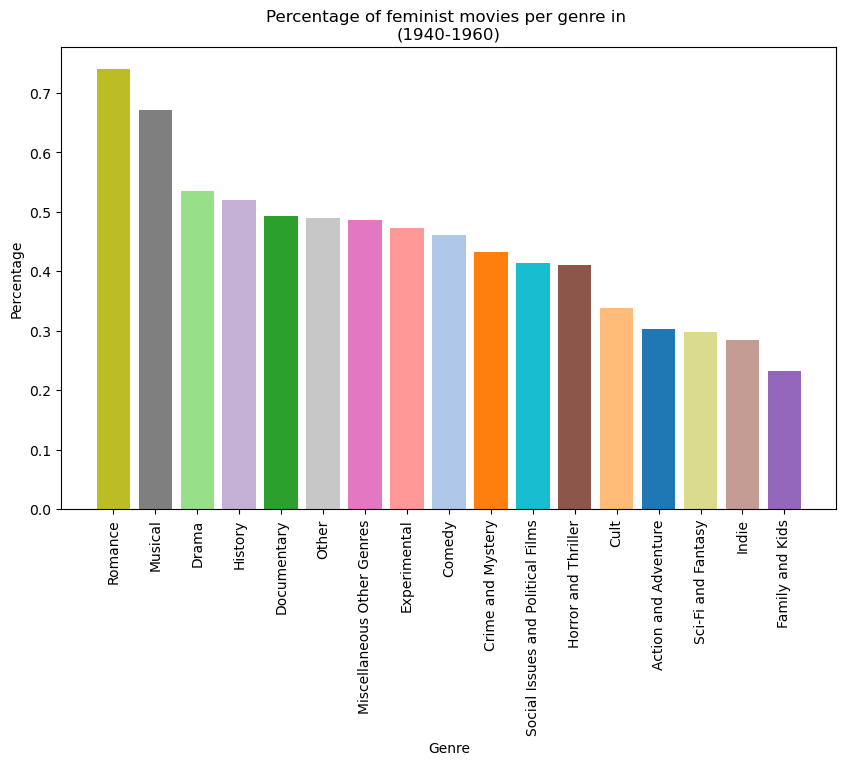

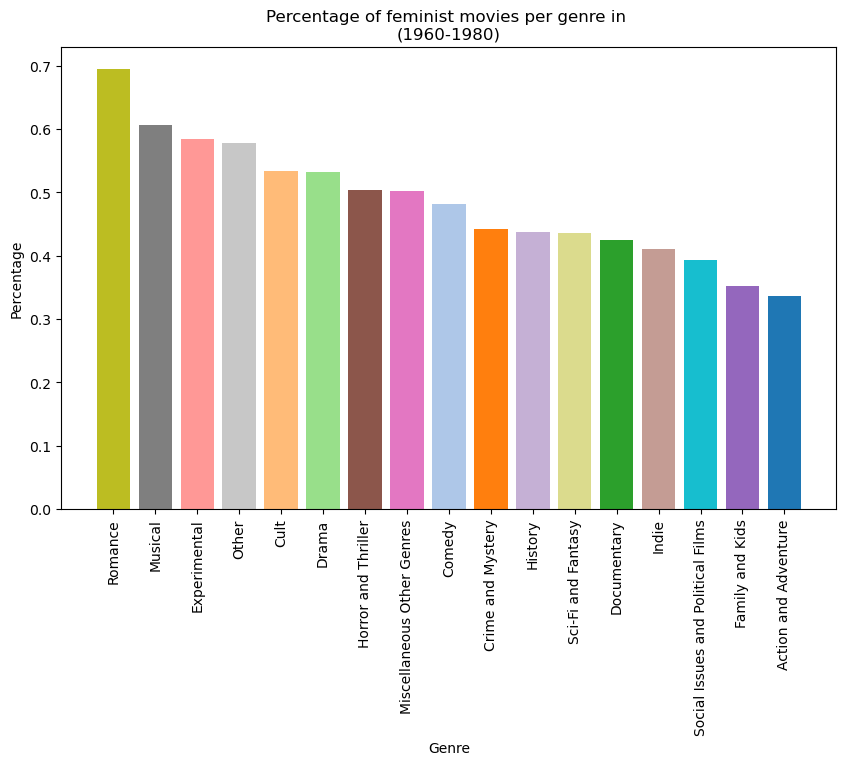

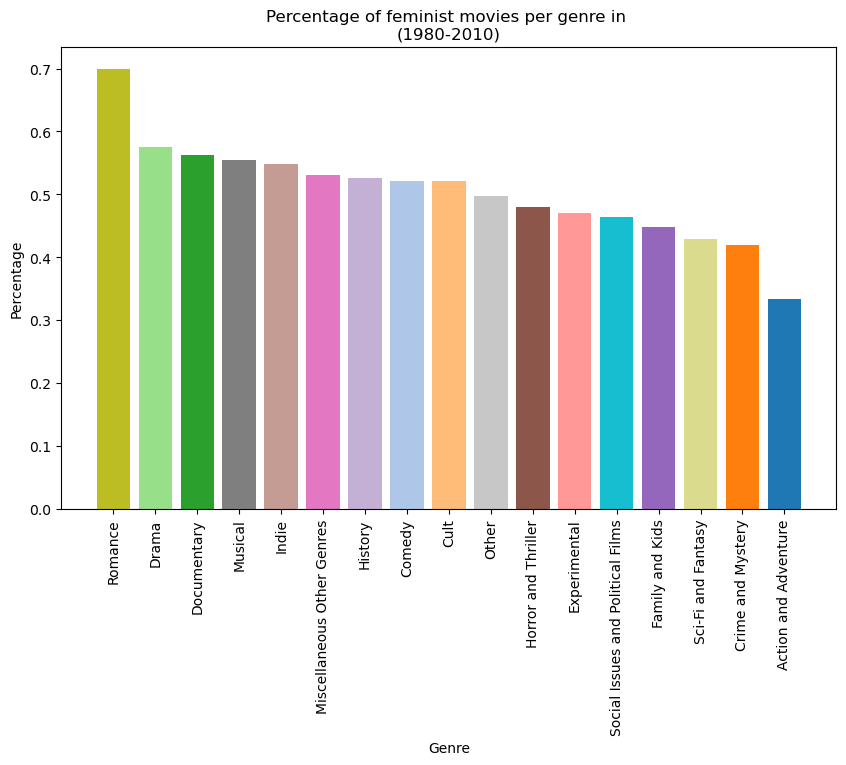

In [63]:
movie_dataset = pd.read_csv(file_source + 'Prediction csv files/movie_feminism_dataset_gpt2_prediction.csv')

movie_dataset['genres'] = movie_dataset['Movie genres (Freebase ID:name tuples)'].apply(extract_genres)

movie_dataset_explode_genre = movie_dataset.explode('genres')

movie_dataset_explode_genre['genre_general'] = movie_dataset_explode_genre['genres'].apply(categorize_genre)

movie_dataset_explode_genre['Period'] = pd.cut(
    movie_dataset['Year'], 
    bins=[1940, 1960, 1980, 2010], 
    labels=['1940-1960', '1960-1980', '1980-2010'],
    right=False
)

movie_dataset_per_genre_period = movie_dataset_explode_genre.groupby(['Period', 'genre_general']).agg(
    movies_feminist = ('feminism', 'sum'),
    nb_total = ('Wikipedia movie ID', 'count')
)

movie_dataset_per_genre_period['percentage_feminism']= movie_dataset_per_genre_period['movies_feminist']/movie_dataset_per_genre_period['nb_total']

periods = ['1940-1960', '1960-1980', '1980-2010']

genres = movie_dataset_per_genre_period.index.get_level_values('genre_general').unique()
genre_colors = {genre: plt.cm.tab20(i / len(genres)) for i, genre in enumerate(genres)}

def plot_period_data(period):
    period_data = movie_dataset_per_genre_period.loc[period]
    
    period_data = period_data.sort_values(by='percentage_feminism', ascending=False)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(
        period_data.index, 
        period_data['percentage_feminism'], 
        color=[genre_colors[genre] for genre in period_data.index]
    )
    plt.title(f'Percentage of feminist movies per genre in \n({period})')
    plt.xticks(rotation=90)  
    plt.ylabel('Percentage')
    plt.xlabel('Genre')
    plt.show()

for period in periods:
    plot_period_data(period)

## Oscar Winners and Nominees

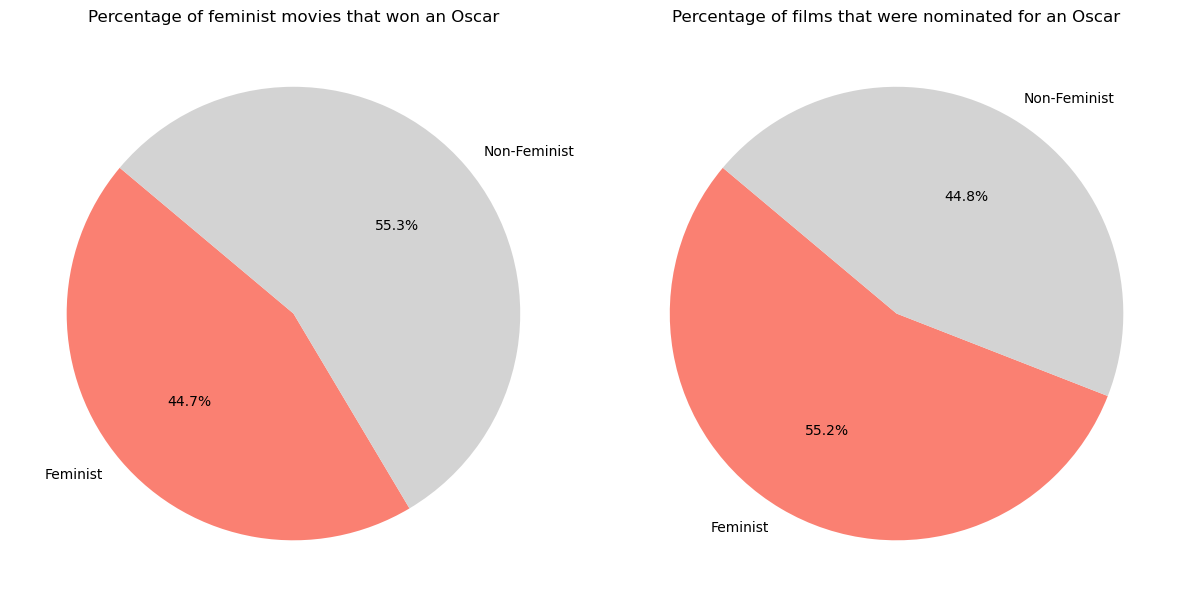

In [64]:
oscars_percentage = pd.merge(movie_dataset, oscars_df, left_on = 'Movie name', right_on = 'Film', how='inner')

columns_to_keep = ['Movie name', 'feminism', 'Award']
oscars_percentage = oscars_percentage[columns_to_keep]

result_oscar = oscars_percentage.groupby('Award').agg(
    movies_feminist = ('feminism', 'sum'),
    nb_total = ('Movie name', 'count')
    )

colors = ['salmon', 'lightgrey']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(
    [result_oscar.loc['Winner', 'movies_feminist'], 
     result_oscar.loc['Winner', 'nb_total'] - result_oscar.loc['Winner', 'movies_feminist']],
    labels=['Feminist', 'Non-Feminist'],
    colors=colors,
    autopct='%1.1f%%',
    startangle=140
)
axes[0].set_title("Percentage of feminist movies that won an Oscar")

axes[1].pie(
    [result_oscar.loc['Nominee', 'movies_feminist'], 
     result_oscar.loc['Nominee', 'nb_total'] - result_oscar.loc['Nominee', 'movies_feminist']],
    labels=['Feminist', 'Non-Feminist'],
    colors=colors,
    autopct='%1.1f%%',
    startangle=140
)
axes[1].set_title("Percentage of films that were nominated for an Oscar")

plt.tight_layout()
plt.show()

## Percentage of feminist movies per country 

In [66]:
movie_dataset['Country dictionnaire'] = movie_dataset['Movie countries (Freebase ID:name tuples)'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

movie_dataset_explode_country = movie_dataset.explode('Country dictionnaire')

movies_per_country = movie_dataset_explode_country.groupby(['Country dictionnaire', 'Year']).agg(
    total_movies=('Wikipedia movie ID', 'count'),
    feminist_movies=('feminism', 'sum')
).reset_index()


films_per_country = movie_dataset_explode_country.groupby('Country dictionnaire').size().reset_index(name='total_movies')
top_5_countries = films_per_country.sort_values(by='total_movies', ascending=False).head(5)
top_countries_name = ['United States of America', "India", 'United Kingdom', 'France', 'Italy']


movies_per_country['percentage'] = movies_per_country['feminist_movies']/movies_per_country['total_movies']

movies_per_country = movies_per_country[(movies_per_country['Year'] >= 1960) & (movies_per_country['Year'] < 2008)]

df = movies_per_country[movies_per_country['Country dictionnaire'].isin(top_5_countries['Country dictionnaire'])]
country_labels = dict(zip(top_5_countries['Country dictionnaire'], top_countries_name))
fig = go.Figure()

for country_code, country_label in country_labels.items():
    country_data = df[df['Country dictionnaire'] == country_code]
    fig.add_trace(go.Scatter(
        x=country_data['Year'],
        y=country_data['percentage'],
        mode='lines',
        name=country_label,
        hovertemplate=f"<b>{country_label}</b><br>Year: {{x}}<br>Percentage: {{y:.2f}}%"  # Affichage interactif
    ))


fig.update_layout(
    title="Percentage of Feminist Movies in Top 5 Movie-Producing Countries (From 1960)",
    xaxis_title="Year",
    yaxis_title="Percentage",
    legend_title="Country",
    template="plotly_white",
    hovermode="x unified"
)

fig.write_html("feminist_movies_by_country.html")

fig.show()

## Sentiment analysis

In this part, we will evaluate whether there is a difference in sentiments portrayed in movies determined as feminist and those not.

In [6]:
movie_dataset = pd.read_csv(file_source + 'Prediction csv files/movie_feminism_dataset_gpt2_prediction.csv')
movie_dataset = movie_dataset.rename(columns={'feminism':"prediction_feminism"})

In [13]:
# Find all of the movies that were predicted feminist by all three models
all_predicted_feminist = predictions_df.copy()

for index, row in predictions_df.iterrows():
    if row['is_equal'] == True and row['prediction_gpt']== 1:
        movie_id = row['Wikipedia movie ID']
        corresponding_row = movie_dataset.loc[movie_dataset['Wikipedia movie ID']==movie_id]
        if (len(corresponding_row['prediction_feminism']) > 0 and corresponding_row['prediction_feminism'].iloc[0] == 0):
            all_predicted_feminist.drop(index, inplace=True)
        elif (len(corresponding_row['prediction_feminism']) == 0):
            all_predicted_feminist.drop(index, inplace=True)
    else :
        all_predicted_feminist.drop(index, inplace=True)

In [14]:
# Find all of the movies that were predicted non-feminist by all three models
all_predicted_non_feminist = predictions_df.copy()

for index, row in predictions_df.iterrows():
    if row['is_equal'] == True and row['prediction_gpt']== 0:
        movie_id = row['Wikipedia movie ID']
        corresponding_row = movie_dataset.loc[movie_dataset['Wikipedia movie ID']==movie_id]
        if (len(corresponding_row['prediction_feminism']) > 0 and corresponding_row['prediction_feminism'].iloc[0] == 1):
            all_predicted_non_feminist.drop(index, inplace=True)
        elif (len(corresponding_row['prediction_feminism']) == 0):
            all_predicted_non_feminist.drop(index, inplace=True)
    else :
        all_predicted_non_feminist.drop(index, inplace=True)

In [16]:
# Keep only the movie plots
feminist_movie_plots = all_predicted_feminist['Summaries']
non_feminist_movie_plots = all_predicted_non_feminist['Summaries']

In [22]:
# Load the nlp library and convert to docs
nlp = spacy.load('en_core_web_sm')

feminist_docs = []
for summary in feminist_movie_plots :
    doc = nlp(summary)
    feminist_docs.append(doc)

non_feminist_docs = []
for summary in non_feminist_movie_plots :
    doc = nlp(summary)
    non_feminist_docs.append(doc)

In [23]:
# Load the VADER sentiment analyser
analyzer = SentimentIntensityAnalyzer()

# Perform sentiment analysis
analysed_array_feminist = []
for sentence in feminist_docs[1].sents:
    analysed = analyzer.polarity_scores(sentence.text)
    analysed_array_feminist.append(analysed)

analysed_array_nonFeminist = []
for plot in non_feminist_docs:
    for sentence in plot.sents:
        analysed = analyzer.polarity_scores(sentence.text)
        analysed_array_nonFeminist.append(analysed)

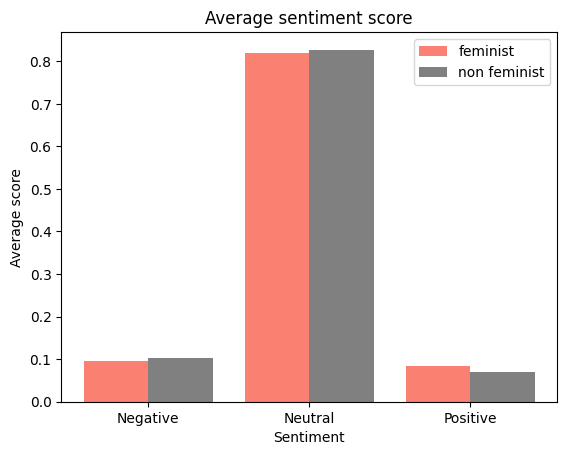

In [26]:
# Compute the averages
avg_negative_feminist = np.mean([analysed['neg'] for analysed in analysed_array_feminist])
avg_neutral_feminist = np.mean([analysed['neu'] for analysed in analysed_array_feminist])
avg_positive_feminist = np.mean([analysed['pos'] for analysed in analysed_array_feminist])

avg_negative_nonFeminist = np.mean([analysed['neg'] for analysed in analysed_array_nonFeminist])
avg_neutral_nonFeminist = np.mean([analysed['neu'] for analysed in analysed_array_nonFeminist])
avg_positive_nonFeminist = np.mean([analysed['pos'] for analysed in analysed_array_nonFeminist])

averages_feminist = [avg_negative_feminist, avg_neutral_feminist, avg_positive_feminist]
averages_nonFeminist = [avg_negative_nonFeminist,avg_neutral_nonFeminist,avg_positive_nonFeminist]

# Plot the results
X_axis = np.arange(3) 
plt.bar(X_axis - 0.2, averages_feminist, 0.4, label = 'feminist', color = 'salmon') 
plt.bar(X_axis + 0.2, averages_nonFeminist, 0.4, label = 'non feminist', color = 'grey') 

categories = ['Negative', 'Neutral', 'Positive']

plt.xticks(X_axis, categories) 
plt.xlabel("Sentiment") 
plt.ylabel("Average score") 
plt.title("Average sentiment score") 
plt.legend() 
plt.show() 

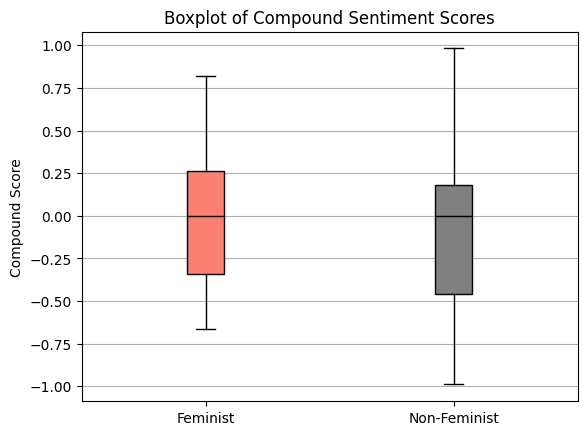

In [30]:
# Get the compound scores
compound_scores_feminist = [analysed['compound'] for analysed in analysed_array_feminist]
compound_scores_nonFeminist = [analysed['compound'] for analysed in analysed_array_nonFeminist]

# Combine
compound_scores_all = [
    compound_scores_feminist,
    compound_scores_nonFeminist
]

# Plot scores in boxplots
box = plt.boxplot(compound_scores_all, tick_labels=['Feminist', 'Non-Feminist'], patch_artist=True, notch=False, 
                  boxprops=dict(color='black'),
                  medianprops=dict(color='black'))

colors = ['salmon', 'grey']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Boxplot of Compound Sentiment Scores')
plt.ylabel('Compound Score')
plt.grid(axis='y')

plt.show()

## Parallel coordinates plot
The use of a parallel coordinates plot can help understand if there are some differences between feminist and non-feminist movies regarding the features such as year, movie duration and others.

In [31]:
# Function to preprocess country column
def extract_country(country_str):
    try:
        # Convert the genre string (which is in JSON format) to a dictionary
        country_dict = json.loads(country_str)
        # Extract genre names from the dictionary (the values)
        countries = list(country_dict.values())
        return countries
    except Exception as e:
        # In case of an error in parsing, return an empty list or handle the error appropriately
        return []

# Function to preprocess language column
def extract_languages(language_str):
    try:
        # Convert the genre string (which is in JSON format) to a dictionary
        language_dict = json.loads(language_str)
        # Extract genre names from the dictionary (the values)
        language = list(language_dict.values())
        return language
    except Exception as e:
        # In case of an error in parsing, return an empty list or handle the error appropriately
        return []

movie_dataset_processed = movie_dataset.copy()
movie_dataset_processed['genres'] = movie_dataset_processed['Movie genres (Freebase ID:name tuples)'].apply(extract_genres)
movie_dataset_processed['countries'] = movie_dataset_processed['Movie countries (Freebase ID:name tuples)'].apply(extract_country)
movie_dataset_processed['languages'] = movie_dataset_processed['Movie languages (Freebase ID:name tuples)'].apply(extract_languages)

# Exploding the genres into separate rows, as a movie can belong to multiple genres
movie_dataset_processed = movie_dataset_processed.explode('genres')
movie_dataset_processed = movie_dataset_processed.explode('languages')
movie_dataset_processed = movie_dataset_processed.explode('countries')

In [32]:
# Group the genres
genre_to_group = {}
for group, genres_list in genres_grouped.items():
    for genre in genres_list:
        genre_to_group[genre] = group

def categorize_genre(genre):
    return genre_to_group.get(genre, 'Other')

# Drop the unecessary columns:
movie_dataset_processed['genre_general'] = movie_dataset_processed['genres'].apply(categorize_genre)
movie_dataset_processed = movie_dataset_processed.drop(columns=['genres', 'Movie genres (Freebase ID:name tuples)','Movie languages (Freebase ID:name tuples)','Movie countries (Freebase ID:name tuples)','Summaries','Freebase movie ID'])
movie_dataset_processed = movie_dataset_processed.drop_duplicates()
movie_dataset_processed = movie_dataset_processed.dropna()

In [35]:
# Seperate into feminsit and non-feminst predictions
feminist_predictions = movie_dataset_processed[movie_dataset_processed['prediction_feminism']==1]
non_feminist_predictions = movie_dataset_processed[movie_dataset_processed['prediction_feminism']==0]

# Sample to keep a portion of the movies for better readability
sampled_feminist = feminist_predictions.sample(n=1000, random_state=42) 
sampled_non_feminist = non_feminist_predictions.sample(n=1000, random_state=42) 
both_sampled = pd.concat([sampled_feminist,sampled_non_feminist])
both_sampled['prediction_feminism'] = 1 - both_sampled['prediction_feminism'] # swap zeros and ones for better visibility in the plot

In [36]:
# Make categorical values into numbers
sorted_countries = sorted(both_sampled['countries'].unique())
sorted_languages = sorted(both_sampled['languages'].unique())

# Keep 10 evenly spaced categories
selected_countries = sorted_countries[::max(1, len(sorted_countries) // 10)]
selected_languages = sorted_languages[::max(1, len(sorted_languages) // 10)]

# Encode categorical columns
both_sampled['countries_encoded'] = both_sampled['countries'].astype('category').cat.codes
both_sampled['languages_encoded'] = both_sampled['languages'].astype('category').cat.codes
both_sampled['genre_general_encoded'] = both_sampled['genre_general'].astype('category').cat.codes

# Get the categories of counry and language as well as their indices
country_categories = both_sampled['countries'].astype('category').cat.categories
language_categories = both_sampled['languages'].astype('category').cat.categories
selected_country_indices = [country_categories.get_loc(country) for country in selected_countries]
selected_language_indices = [language_categories.get_loc(language) for language in selected_languages]

In [37]:
# Create the parallel coordinates plot
parcoords = go.Parcoords(
    line=dict(color=both_sampled['prediction_feminism'], 
              colorscale=['salmon','grey'], 
              showscale=False),
    dimensions=[
        dict(label='Movie Box Office Revenue', values=both_sampled['Movie box office revenue']),
        dict(label='Movie Runtime', values=both_sampled['Movie runtime']),
        dict(label='Year', values=both_sampled['Year']),
        dict(label='Countries', values=both_sampled['countries_encoded'],
             tickvals=selected_country_indices, ticktext=selected_countries),
        dict(label='Languages', values=both_sampled['languages_encoded'],
             tickvals=selected_language_indices, ticktext=selected_languages),
        dict(label='Genre', values=both_sampled['genre_general_encoded'],
             tickvals=list(range(len(both_sampled['genre_general'].unique()))),
             ticktext=both_sampled['genre_general'].unique())
    ]
)

# For the legend to appear, create invisible scatter plots
legend_feminist = go.Scatter(
    x=[None], y=[None], 
    mode='markers',
    marker=dict(size=10, color='salmon'),
    name='Feminist'
)

legend_non_feminist = go.Scatter(
    x=[None], y=[None],
    mode='markers',
    marker=dict(size=10, color='grey'),
    name='Non-Feminist'
)

# Combine the plot with the legend
fig = go.Figure(data=[parcoords, legend_feminist, legend_non_feminist])

# Update layout to show the legend
fig.update_layout(
    legend=dict(
        title="Movie Type",
        x=1, 
        y=1,
        itemsizing='constant',
    )
)

# Show the plot
fig.show()
fig.write_html('parallel_plot')

## Graph theory 

We will use graph theory to visualise links between movies and their predictions

### Connections between feminist predictions 

In [42]:
predictions_SVM_df = pd.read_csv('movies_svm_predictions.csv')
predictions_SVM_df = predictions_SVM_df.rename(columns={'Feminism prediction':"prediction_svm"})

# Create a dataframe that contains the connections between movies and their respective model
df = pd.DataFrame(columns=['Source', 'Target'])

for index, movie in predictions_gpt_df.iterrows():
    movie_name = movie['Movie name']
    if  movie['prediction_gpt'] == 1 :
        df.loc[len(df)] = [movie_name, 'gpt']

for index, movie in predictions_SVM_df.iterrows():
    movie_name = movie['Movie name']
    if  movie['prediction_svm'] == 1 :
        df.loc[len(df)] = [movie_name, 'svm']

for index, movie in movie_dataset.iterrows():
    movie_name = movie['Movie name']
    if  movie['prediction_feminism'] == 1 :
        df.loc[len(df)] = [movie_name, 'gpt2']

In [43]:
# Group all of the prediction models for each movie
movie_categories = df.groupby('Source')['Target'].agg(set).reset_index()
movie_categories['model_count'] = movie_categories['Target'].apply(len) # Add the number of models that predicted it feminist
movie_categories

,Source,Target,model_count
0,!Women Art Revolution,"{gpt2, gpt}",2
1,#1 Cheerleader Camp,"{gpt2, gpt}",2
2,$9.99,{svm},1
3,'68,{svm},1
4,'Gator Bait,{gpt2},1
...,...,...,...
25601,Čovek nije tica,"{svm, gpt2}",2
25602,Želary,{gpt2},1
25603,Вчера,{svm},1
25604,…All the Marbles,{gpt2},1


In [47]:
# Sample a group of the data by keeping the same fraction of movies in order to have better visibility
sampled_df = pd.DataFrame()
grouped_df = movie_categories.groupby('model_count', group_keys=False)
sampled_df = pd.concat([group.sample(frac=0.1, random_state=42) for _, group in grouped_df]).reset_index(drop=True) # we keep 10% of the data

# Split back the data into a single model per line
sampled_df = sampled_df.drop(columns='model_count')
sampled_df = sampled_df.explode('Target')

# Reset the index for a clean DataFrame
sampled_df = sampled_df.reset_index(drop=True)
sampled_df

,Source,Target
0,Ambush Valley,gpt2
1,Alaap,gpt2
2,Modhi Vilayadu,svm
3,Rojulu Marayi,gpt2
4,Ezra,svm
...,...,...
4679,The Female Prince,gpt2
4680,The Female Prince,gpt
4681,The New Women,svm
4682,The New Women,gpt2


In [48]:
# Create a nx graph
feminist_themeG =nx.from_pandas_edgelist(sampled_df, 'Source', 'Target', edge_attr=None, create_using= nx.Graph())

In [49]:
# Compute the positions
pos = nx.spring_layout(feminist_themeG)

edge_x = []
edge_y = []
for edge in feminist_themeG.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

node_x = [pos[node][0] for node in feminist_themeG.nodes()]
node_y = [pos[node][1] for node in feminist_themeG.nodes()]

In [52]:
# Plot the network graph
palette = matplotlib.colormaps['magma']

node_colors = []
node_sizes = []  

# Give a specific color to nodes
for node in feminist_themeG.nodes():
    degree = feminist_themeG.degree[node]
    if node == 'svm':
        node_colors.append('red')
        node_sizes.append(degree / 100)  
    elif node == 'gpt':
        node_colors.append('green')
        node_sizes.append(degree / 100)  
    elif node == 'gpt2':
        node_colors.append('blue')
        node_sizes.append(degree / 100)  
    elif degree == 3:
        node_colors.append(mcolors.to_hex(palette(0.55)))
        node_sizes.append(10)  
    elif degree == 2:
        node_colors.append(mcolors.to_hex(palette(0.8)))
        node_sizes.append(10)  
    elif degree == 1:
        node_colors.append(mcolors.to_hex(palette(0.99)))
        node_sizes.append(10) 

# Add hover text to nodes
node_text = []
for node, adjacencies in feminist_themeG.adjacency():
    node_text.append(f"{node}<br># of connections: {len(adjacencies)}")


fig = go.Figure(layout=go.Layout(
    title='Feminist movies predictions by model',
    titlefont_size=16,
    showlegend=True,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=30),
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False)
))

# Edges
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines',
    name='Feminist movie <--> Model connection'
))

# Nodes
fig.add_trace(go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    marker=dict(size=node_sizes, color=node_colors),
    text=node_text,
    hoverinfo='text',
    showlegend=False  # General nodes won't appear in the legend
))

# Add SVM, GPT, GPT-2 nodes on top
for model, color in zip(['svm', 'gpt', 'gpt2'], ['red', 'green', 'blue']):
    model_node_x = [node_x[i] for i, node in enumerate(feminist_themeG.nodes()) if node.lower() == model.lower()]
    model_node_y = [node_y[i] for i, node in enumerate(feminist_themeG.nodes()) if node.lower() == model.lower()]
    model_node_text = [node_text[i] for i, node in enumerate(feminist_themeG.nodes()) if node.lower() == model.lower()]
    
    fig.add_trace(go.Scatter(
        x=model_node_x,
        y=model_node_y,
        mode='markers',
        marker=dict(size=20, color=color),  
        text=model_node_text,
        hoverinfo='text',
        showlegend=False 
    ))

# Dummy traces for the legend
fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='markers',
    marker=dict(size=15, color='red'),
    name='SVM'
))

fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='markers',
    marker=dict(size=15, color='green'),
    name='GPT'
))

fig.add_trace(go.Scatter(
    x=[None], y=[None],
    mode='markers',
    marker=dict(size=15, color='blue'),
    name='GPT-2'
))

# Show figure
fig.show()
fig.write_html("graph_movie_model_predictions.html")


### Connections in topics of movie summaries

We will now analyse how topics in a movie summary of a feminist movie are connected

In [54]:
# Select a few movies to analyse
movie_names = movie_dataset['Movie name'].unique()
movie_names = movie_names[0:20]

In [58]:
# Create the function to analyse and plot the movie summary topics
def dropdown_movie_plot(movie_names):

    # Select the movie summary
    def select_movie(movie_name):
        movie = movie_dataset[movie_dataset['Movie name'] == movie_name]
        movie_summary = movie.iloc[0]['Summaries']
        return movie_summary

    def extract_keywords(summary):
        # Initialize KeyBERT model
        kw_model = KeyBERT()

        # Extract keywords --> we keep a phrase of 2 words
        key_words = kw_model.extract_keywords(summary, keyphrase_ngram_range=(1, 2), top_n=8)
        return key_words

    # Create the dataframe to have the links between each word in the keyphrase
    def find_interactions(keywords):
        df_key_words = pd.DataFrame(columns=['Source', 'Target', 'importance'])

        for keyphrase in keywords:
            phrase = keyphrase[0]
            split_phrase = phrase.split(' ')
            importance = keyphrase[1]
            if len(split_phrase) > 1:
                df_key_words.loc[len(df_key_words)] = [split_phrase[0], split_phrase[1], importance]
        return df_key_words

    # Plot as a network graph
    def plot_interactions(df_key_words):
        graph_key_phrases = nx.from_pandas_edgelist( df_key_words, source='Source', target='Target', edge_attr='importance',create_using=nx.Graph())
        
        # Compute the positions of the nodes and edges
        pos = nx.spring_layout(graph_key_phrases) 

        edge_x = []
        edge_y = []
        edge_text = []
        node_text = []
        node_adjacencies = []
        for edge in graph_key_phrases.edges(data=True):
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x += [x0, x1, None]
            edge_y += [y0, y1, None]

            # Text when hover over the edges
            importance = edge[2].get('importance', 0.0)
            edge_text.append(f"{edge[0]} - {edge[1]}<br>Importance: {importance:.2f}")

        # Text for the nodes
        for node, adjacencies in graph_key_phrases.adjacency():
            node_adjacencies.append(len(adjacencies)) 
            node_text.append(f"{node}")

        # Extract node information
        node_x = [pos[node][0] for node in graph_key_phrases.nodes()]
        node_y = [pos[node][1] for node in graph_key_phrases.nodes()]

        return edge_x, edge_y, edge_text, node_x, node_y, node_text

    # Create the initial plot with the movie 'Taxi Blues'
    summary = select_movie('Taxi Blues')
    keywords = extract_keywords(summary)
    interaction_dataframe = find_interactions(keywords)
    edge_x, edge_y, edge_text, node_x, node_y, node_text = plot_interactions(interaction_dataframe)

    fig = go.Figure()

    # Ddges
    fig.add_trace(go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color="gray"),
        hoverinfo="text",
        text=edge_text,
        mode="lines"
    ))

    # Nodes
    fig.add_trace(go.Scatter(
        x=node_x, y=node_y,
        mode="markers+text",
        marker=dict(size=15, color="salmon"),
        text=node_text,  # Node labels
        hoverinfo="text"
    ))

    # Initial title
    fig.update_layout(
        title="Movie name: Taxi Blues",
        showlegend=False,
        hovermode="closest",
        margin=dict(b=0, l=10, r=0, t=30),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )

    # Create the dropdown menu to select the movies
    dropdown_buttons = []
    for movie in movie_names:
        summary = select_movie(movie)
        keywords = extract_keywords(summary)
        interaction_dataframe = find_interactions(keywords)
        edge_x, edge_y, edge_text, node_x, node_y, node_text = plot_interactions(interaction_dataframe)

        dropdown_buttons.append({
            "label": movie,
            "method": "update",
            "args": [ {"x": [edge_x, node_x], "y": [edge_y, node_y], "text": [None, node_text]}, {"title": f"Movie name: {movie}"}]
        })

    # Add dropdown 
    fig.update_layout( updatemenus=[{ "buttons": dropdown_buttons, "direction": "down", "showactive": True}])

    # Show the graph
    fig.show()
    fig.write_html("movie_topic_interactions.html")
    
dropdown_movie_plot(movie_names)